In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import os

japanize_matplotlib.japanize() 

In [76]:
raw_data = pd.read_csv('./data/maikin/all_cleaned.csv', encoding='utf_8_sig', low_memory=False)
raw_data.head()

,年,月,産業分類,規模,就業形態,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,増加労働者数,減少労働者数,本月末労働者数,パートタイム労働者数
0,1960,CY,C,0,0,26250,22547.0,NaN,NaN,3703.0,193.6,170.8,22.8,23.0,NaN,NaN,NaN,NaN,NaN
1,1960,CY,C,4,0,28786,24682.0,NaN,NaN,NaN,193.2,168.4,24.8,22.8,NaN,NaN,NaN,NaN,NaN
2,1960,CY,C,5,0,22422,19121.0,NaN,NaN,NaN,196.7,175.1,21.6,23.5,NaN,NaN,NaN,NaN,NaN
3,1960,CY,C,7,0,18826,16814.0,NaN,NaN,NaN,187.9,176.3,11.6,23.4,NaN,NaN,NaN,NaN,NaN
4,1960,CY,D,0,0,21213,17952.0,NaN,NaN,3261.0,211.0,186.4,24.6,24.1,NaN,NaN,NaN,NaN,NaN


## 前処理

In [79]:
# 1995年以降のデータを抽出
all_data = raw_data[raw_data["年"] >= 1995]

# 月 = CY（年平均）のデータのみを抽出
all_data = all_data[all_data["月"] == "CY"]
all_data = all_data.drop(columns=["月"])

# 規模 = "T"（5人以上）、"4"（500人以上）, "5"（100~499）、"7"（30~99）、"9"のデータのみを抽出
all_data = all_data[all_data["規模"].isin(["T", "4", "5", "7", "9"])]

# 規模 = "5", "7", "9"を中小企業とし、カテゴリ"M"にする。賃金は平均をとり、労働者数は合計をとる
all_data.loc[all_data["規模"].isin(["5", "7", "9"]), "規模"] = "M"
all_data = all_data.groupby(["年", "産業分類", "規模", "就業形態"]).agg({
    "現金給与総額": "mean",
    "きまって支給する給与": "mean",
    "所定内給与": "mean",
    "所定外給与": "mean",
    "特別給与": "mean",
    "総実労働時間": "mean",
    "所定内労働時間": "mean",
    "所定外労働時間": "mean",
    "出勤日数": "mean",
    "前月末労働者数": "sum",
    "本月末労働者数": "sum",
    "パートタイム労働者数": "sum",
    "増加労働者数": "sum",
    "減少労働者数": "sum",
}).reset_index()

# 就業形態 = 1（一般労働者）のみを抽出
all_data = all_data[all_data["就業形態"] == 1]
all_data = all_data.drop(columns=["就業形態", "パートタイム労働者数"])

all_data.head()

,年,産業分類,規模,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,本月末労働者数,増加労働者数,減少労働者数
1,1995,C,4,521444.000000,408215.000000,328758.000000,79457.000000,113229.000000,205.200000,168.600000,36.600000,22.600000,6987.0,6964.0,80.0,102.0
4,1995,C,M,387615.333333,302702.000000,282563.333333,20138.666667,84913.333333,173.100000,162.566667,10.533333,21.466667,57300.0,57159.0,584.0,654.0
7,1995,C,T,374611.000000,301852.000000,276967.000000,24885.000000,72759.000000,180.600000,167.400000,13.200000,21.900000,64287.0,64123.0,664.0,756.0
10,1995,D,4,642039.000000,449082.000000,414135.000000,34947.000000,192957.000000,170.100000,154.300000,15.800000,20.200000,158179.0,157883.0,1378.0,1675.0
13,1995,D,M,419254.333333,333122.666667,313619.666667,19503.000000,86131.666667,173.733333,162.500000,11.233333,21.233333,3765015.0,3763572.0,70848.0,72909.0


In [80]:
# 産業分類のカテゴリを確認
all_data["産業分類"].unique()

array(['C', 'D', 'E', 'F', 'TL', 'G', 'H', 'I', 'J', 'O', 'P', 'Q', 'K',
       'L', 'M', 'N', 'R'], dtype=object)

In [81]:
# 大分類のみを使用する（アルファベットのもののみを使用、"TL"も含める）
all_data = all_data[all_data["産業分類"].str.match(r'^[A-Z]$|^TL$')]
all_data["産業分類"].unique()

array(['C', 'D', 'E', 'F', 'TL', 'G', 'H', 'I', 'J', 'O', 'P', 'Q', 'K',
       'L', 'M', 'N', 'R'], dtype=object)

In [82]:
# 労働者数を記録している列は切り上げ
all_data["本月末労働者数"] = np.ceil(all_data["本月末労働者数"])
all_data["前月末労働者数"] = np.ceil(all_data["前月末労働者数"])
# all_data["パートタイム労働者数"] = np.ceil(all_data["パートタイム労働者数"])
all_data["増加労働者数"] = np.ceil(all_data["増加労働者数"])
all_data["減少労働者数"] = np.ceil(all_data["減少労働者数"])

all_data.head()

,年,産業分類,規模,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,本月末労働者数,増加労働者数,減少労働者数
1,1995,C,4,521444.000000,408215.000000,328758.000000,79457.000000,113229.000000,205.200000,168.600000,36.600000,22.600000,6987.0,6964.0,80.0,102.0
4,1995,C,M,387615.333333,302702.000000,282563.333333,20138.666667,84913.333333,173.100000,162.566667,10.533333,21.466667,57300.0,57159.0,584.0,654.0
7,1995,C,T,374611.000000,301852.000000,276967.000000,24885.000000,72759.000000,180.600000,167.400000,13.200000,21.900000,64287.0,64123.0,664.0,756.0
10,1995,D,4,642039.000000,449082.000000,414135.000000,34947.000000,192957.000000,170.100000,154.300000,15.800000,20.200000,158179.0,157883.0,1378.0,1675.0
13,1995,D,M,419254.333333,333122.666667,313619.666667,19503.000000,86131.666667,173.733333,162.500000,11.233333,21.233333,3765015.0,3763572.0,70848.0,72909.0


In [45]:
# 1995年時点の産業分類カテゴリを確認
industry_cat_1995 = all_data[all_data["年"] == 1995]["産業分類"].unique()
industry_cat_1995

array(['C', 'D', 'E', 'F', 'TL'], dtype=object)

In [83]:
all_data.isna().sum()

年             0
産業分類          0
規模            0
現金給与総額        0
きまって支給する給与    0
所定内給与         0
所定外給与         0
特別給与          0
総実労働時間        0
所定内労働時間       0
所定外労働時間       0
出勤日数          0
前月末労働者数       0
本月末労働者数       0
増加労働者数        0
減少労働者数        0
dtype: int64

In [47]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 769 entries, 2650 to 15203
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   年           769 non-null    int64  
 1   産業分類        769 non-null    object 
 2   規模          769 non-null    object 
 3   現金給与総額      769 non-null    int64  
 4   きまって支給する給与  769 non-null    float64
 5   所定内給与       769 non-null    float64
 6   所定外給与       769 non-null    float64
 7   特別給与        769 non-null    float64
 8   総実労働時間      769 non-null    float64
 9   所定内労働時間     769 non-null    float64
 10  所定外労働時間     769 non-null    float64
 11  出勤日数        769 non-null    float64
 12  前月末労働者数     769 non-null    float64
 13  増加労働者数      769 non-null    float64
 14  減少労働者数      769 non-null    float64
 15  本月末労働者数     769 non-null    float64
dtypes: float64(12), int64(2), object(2)
memory usage: 102.1+ KB


In [84]:
all_data.to_csv('./data/maikin/fulltime_emp.csv', index=False, encoding='utf_8_sig')

- 産業分類"TL"は「調査した産業の合計」なので、扱いに注意

## EDA

### 製造業の対他産業賃金比

#### 全規模

In [56]:
all_wages = pd.read_csv('./data/maikin/fulltime_emp.csv', encoding='utf_8_sig', low_memory=False)
all_wages = all_wages[["年", "規模", "産業分類", "本月末労働者数", "現金給与総額", "きまって支給する給与", "所定内給与", "所定外給与", "特別給与", "所定内労働時間", "所定外労働時間"]]
all_wages = all_wages.rename(columns={
    "本月末労働者数": "労働者数",
})
all_wages.head()

,年,規模,産業分類,労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間
0,1995,4,C,6964.0,521444.000000,408215.000000,328758.000000,79457.000000,113229.000000,168.600000,36.600000
1,1995,M,C,57159.0,387615.333333,302702.000000,282563.333333,20138.666667,84913.333333,162.566667,10.533333
2,1995,T,C,64123.0,374611.000000,301852.000000,276967.000000,24885.000000,72759.000000,167.400000,13.200000
3,1995,4,D,157883.0,642039.000000,449082.000000,414135.000000,34947.000000,192957.000000,154.300000,15.800000
4,1995,M,D,3763572.0,419254.333333,333122.666667,313619.666667,19503.000000,86131.666667,162.500000,11.233333


In [57]:
# 規模が"T"（5人以上）のデータのみを抽出
size_t_wages = all_wages[all_wages["規模"].isin(["T"])]
size_t_wages = size_t_wages.drop(columns=["規模"])
size_t_wages.head()

,年,産業分類,労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間
2,1995,C,64123.0,374611.0,301852.0,276967.0,24885.0,72759.0,167.4,13.2
5,1995,D,3921455.0,388111.0,319960.0,303939.0,16021.0,68151.0,164.6,9.7
8,1995,E,9696646.0,388186.0,299759.0,272771.0,26988.0,88427.0,156.9,13.1
11,1995,F,320772.0,575765.0,414974.0,371855.0,43119.0,160791.0,147.0,12.3
14,1995,TL,34684417.0,408425.0,314595.0,293819.0,20776.0,93830.0,158.8,11.0


In [58]:
# その年の製造業に対する賃金比率を計算、小数点第3位まで
size_t_wages["対製造業賃金比率"] = size_t_wages.apply(lambda row: round(row["現金給与総額"] / size_t_wages[(size_t_wages["年"] == row["年"]) & (size_t_wages["産業分類"] == "E")]["現金給与総額"].values[0], 3), axis=1)
size_t_wages.head()

,年,産業分類,労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間,対製造業賃金比率
2,1995,C,64123.0,374611.0,301852.0,276967.0,24885.0,72759.0,167.4,13.2,0.965
5,1995,D,3921455.0,388111.0,319960.0,303939.0,16021.0,68151.0,164.6,9.7,1.000
8,1995,E,9696646.0,388186.0,299759.0,272771.0,26988.0,88427.0,156.9,13.1,1.000
11,1995,F,320772.0,575765.0,414974.0,371855.0,43119.0,160791.0,147.0,12.3,1.483
14,1995,TL,34684417.0,408425.0,314595.0,293819.0,20776.0,93830.0,158.8,11.0,1.052


In [59]:
# より明確に色を分けるために、複数のカラーマップを結合して使用
# tab20, tab20b, tab20c を結合して最大60色まで対応
import matplotlib.cm as cm
cmap1 = cm.get_cmap("tab20", 20)
cmap2 = cm.get_cmap("tab20b", 20)
cmap3 = cm.get_cmap("tab20c", 20)
colors = [cmap1(i) for i in range(20)] + [cmap2(i) for i in range(20)] + [cmap3(i) for i in range(20)]

C:\Users\chika\AppData\Local\Temp\ipykernel_3776\2134017016.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap("tab20", 20)
C:\Users\chika\AppData\Local\Temp\ipykernel_3776\2134017016.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap("tab20b", 20)
C:\Users\chika\AppData\Local\Temp\ipykernel_3776\2134017016.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap3 = cm.get_cmap("tab20c", 20)


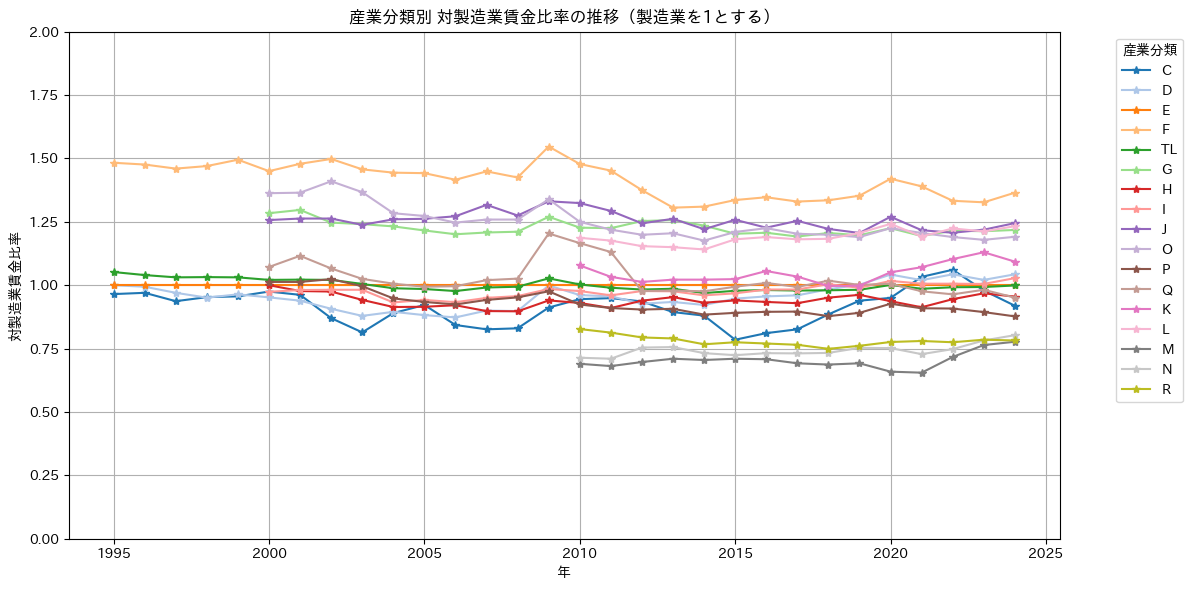

In [62]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

industries = size_t_wages["産業分類"].unique()

for i, industry in enumerate(industries):
    # 色のリストの範囲内で色を選択（足りない場合は循環）
    color = colors[i % len(colors)]
    industry_data = size_t_wages[size_t_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["対製造業賃金比率"], marker='*', label=industry, color=color)

plt.xlabel("年")
plt.ylabel("対製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 対製造業賃金比率の推移（製造業を1とする）")
plt.legend(title="産業分類", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

- 以下の区別に分類する
    - 常に下回るもの
    - 交差するもの
    - 常に上回るもの

In [64]:
# 各産業分類を製造業賃金比率の値によって分類
cat_lower = []
cat_upper = []
cat_cross = []

for industry in size_t_wages["産業分類"].unique():
    industry_data = size_t_wages[size_t_wages["産業分類"] == industry]
    ratios = industry_data["対製造業賃金比率"].values
    
    # すべての値が1.0より大きい
    if all(ratio > 1.0 for ratio in ratios):
        cat_upper.append(industry)
    # すべての値が1.0より小さい
    elif all(ratio < 1.0 for ratio in ratios):
        cat_lower.append(industry)
    # それ以外（交差する）
    else:
        cat_cross.append(industry)

print("常に上回る産業:", cat_upper)
print("常に下回る産業:", cat_lower)
print("交差する産業:", cat_cross)

常に上回る産業: ['F', 'G', 'J', 'O', 'L']
常に下回る産業: ['M', 'N', 'R']
交差する産業: ['C', 'D', 'E', 'TL', 'H', 'I', 'P', 'Q', 'K']


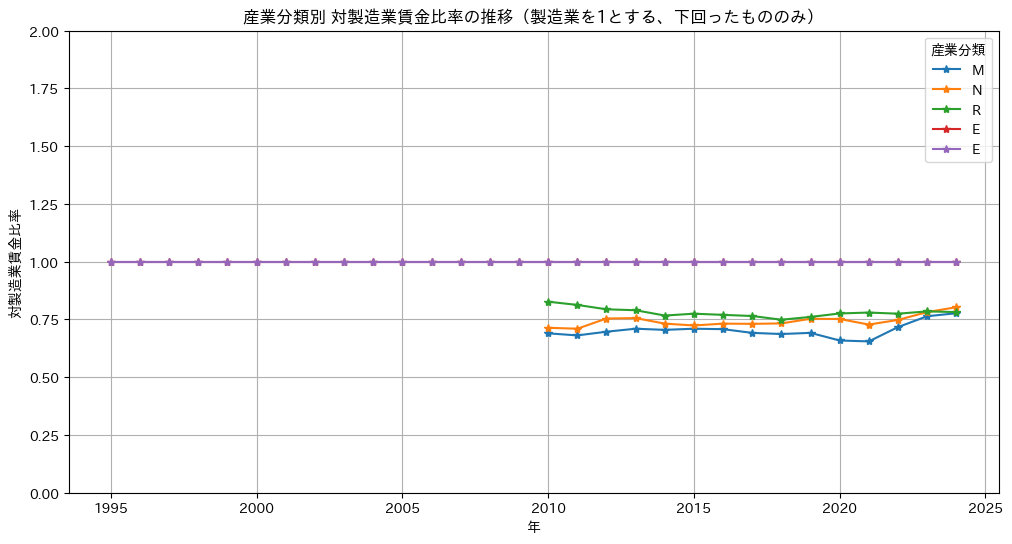

In [67]:
plt.figure(figsize=(12, 6))

cat_lower.append("E")

for industry in cat_lower:
    industry_data = size_t_wages[size_t_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["対製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("対製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 対製造業賃金比率の推移（製造業を1とする、下回ったもののみ）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

産業分類は
- M：宿泊業、飲食サービス業
- N：生活関連サービス業、娯楽業

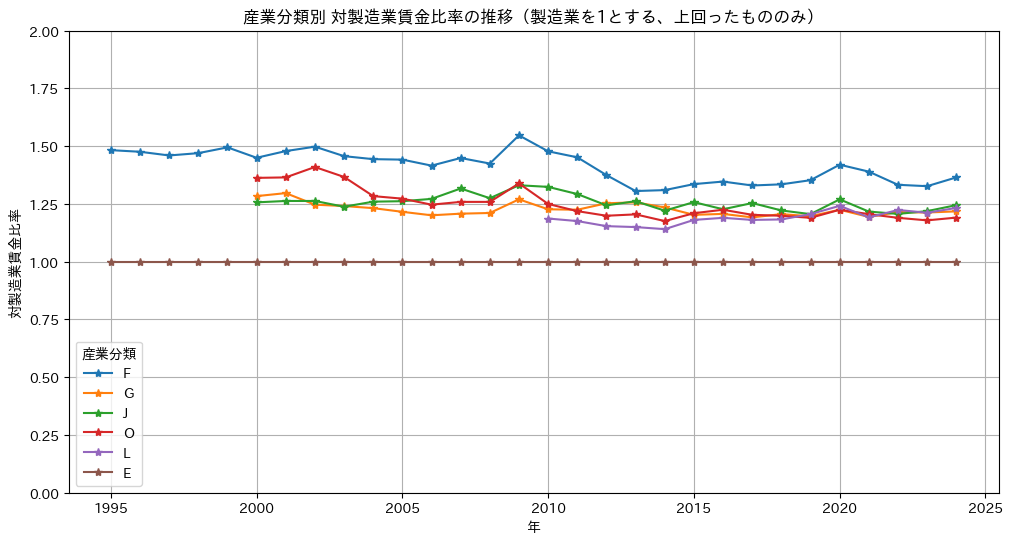

In [66]:
plt.figure(figsize=(12, 6))

cat_upper.append("E")

for industry in cat_upper:
    industry_data = size_t_wages[size_t_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["対製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("対製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 対製造業賃金比率の推移（製造業を1とする、上回ったもののみ）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

産業分類は
- F：電気・ガス・熱供給・水道業
- J：金融業、保険業
- L：学術研究、専門・技術サービス業
- G：情報通信業

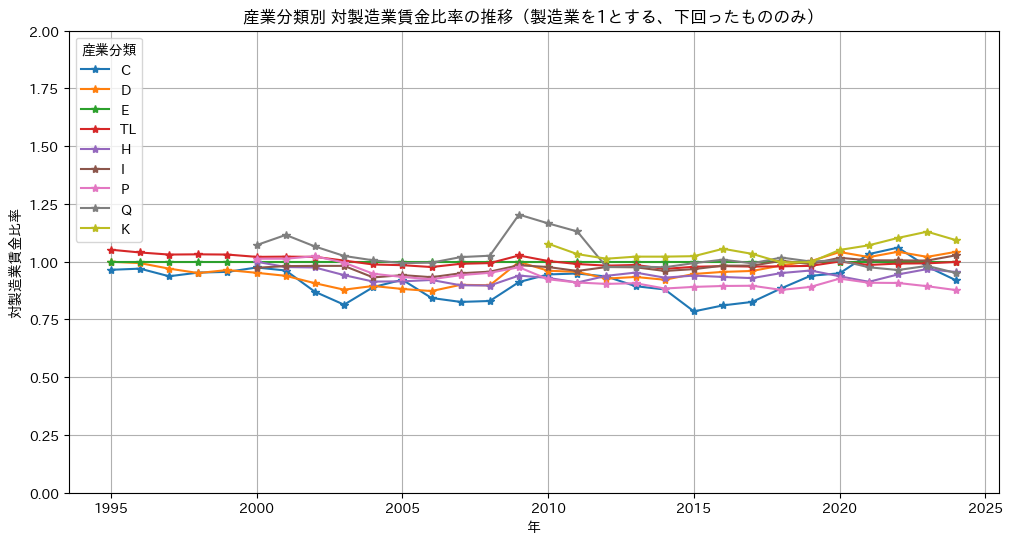

In [68]:
plt.figure(figsize=(12, 6))

for industry in cat_cross:
    industry_data = size_t_wages[size_t_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["対製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("対製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 対製造業賃金比率の推移（製造業を1とする、下回ったもののみ）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

企業規模によっても、賃金は異なる。
特に日本は[全企業数の99.7%が中小企業](https://www.smrj.go.jp/recruit/environment.html)と言われており、データはロングテールになっていることを考慮すべきだと考える。
大企業と中小企業を分けて考えるべきではないか。

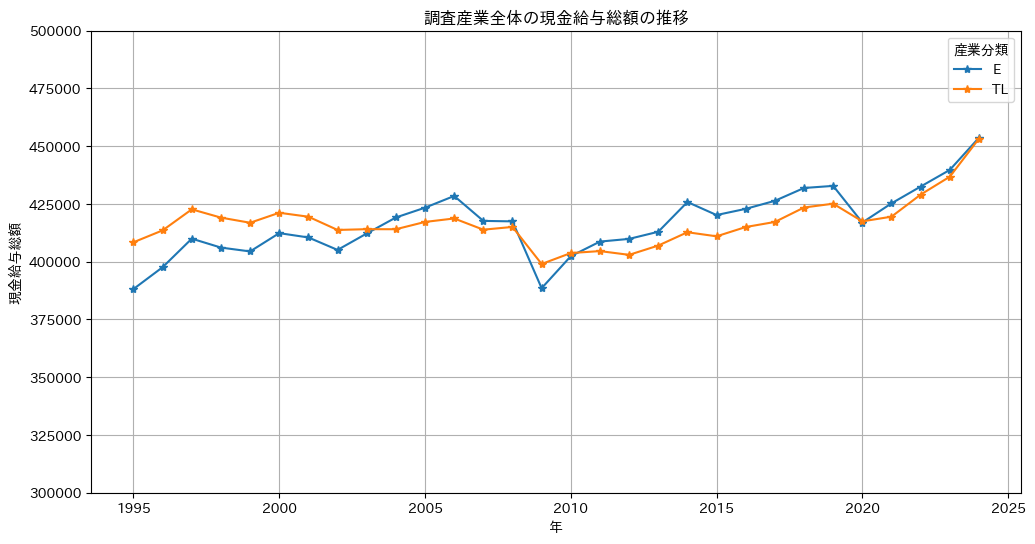

In [62]:
# E（製造業）とT（調査産業計）のみでプロット
wages_e_and_tl = size_t_wages[size_t_wages["産業分類"].isin(["E", "TL"])]
plt.figure(figsize=(12, 6))

for industry in wages_e_and_tl["産業分類"].unique():
    industry_data = wages_e_and_tl[wages_e_and_tl["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["現金給与総額"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("現金給与総額")
plt.ylim(300000, 500000)
plt.title("調査産業全体の現金給与総額の推移")
plt.legend(title="産業分類")
plt.grid(True)

# 図を保存
plt.savefig("wages_e_and_tl.png")

plt.show()

C:\Users\chika\AppData\Local\Temp\ipykernel_19700\3389875613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wages_e_and_tl["対全産業賃金比率"] = wages_e_and_tl.apply(lambda row: round(row["現金給与総額"] / wages_e_and_tl[(wages_e_and_tl["年"] == row["年"]) & (wages_e_and_tl["産業分類"] == "TL")]["現金給与総額"].values[0], 3), axis=1)


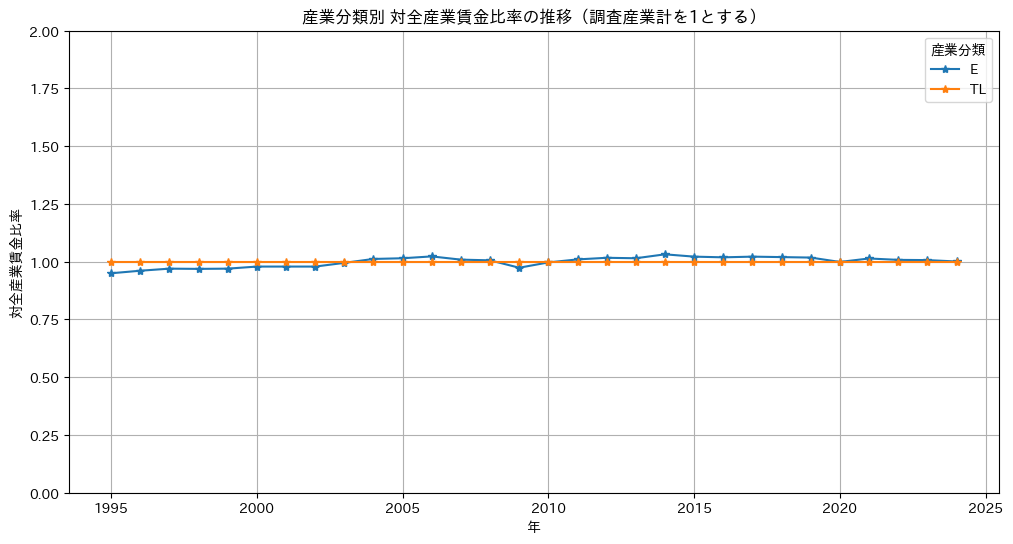

In [72]:
# 製造業の対全産業賃金比率を計算し、プロット
wages_e_and_tl["対全産業賃金比率"] = wages_e_and_tl.apply(lambda row: round(row["現金給与総額"] / wages_e_and_tl[(wages_e_and_tl["年"] == row["年"]) & (wages_e_and_tl["産業分類"] == "TL")]["現金給与総額"].values[0], 3), axis=1)
wages_e_and_tl.head()

plt.figure(figsize=(12, 6))
for industry in wages_e_and_tl["産業分類"].unique():
    industry_data = wages_e_and_tl[wages_e_and_tl["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["対全産業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("対全産業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 対全産業賃金比率の推移（調査産業計を1とする）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

#### 大企業と中小企業を考慮した賃金比

##### 産業構造のEDA

[中小企業・小規模企業者の定義](https://www.chusho.meti.go.jp/soshiki/teigi.html)
- データの区別が細かくないため、今回は5人以上500人未満を中小企業、500人以上を大企業とする

In [2]:
all_wages = pd.read_csv('./data/maikin/fulltime_emp.csv', encoding='utf_8_sig', low_memory=False)
all_wages = all_wages[["年", "規模", "産業分類", "本月末労働者数", "現金給与総額", "きまって支給する給与", "所定内給与", "所定外給与", "特別給与", "所定内労働時間", "所定外労働時間"]]
all_wages = all_wages.rename(columns={
    "本月末労働者数": "労働者数",
})
all_wages.head()

,年,規模,産業分類,労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間
0,1995,4,C,6964.0,521444.000000,408215.000000,328758.000000,79457.000000,113229.000000,168.600000,36.600000
1,1995,M,C,57159.0,387615.333333,302702.000000,282563.333333,20138.666667,84913.333333,162.566667,10.533333
2,1995,T,C,64123.0,374611.000000,301852.000000,276967.000000,24885.000000,72759.000000,167.400000,13.200000
3,1995,4,D,157883.0,642039.000000,449082.000000,414135.000000,34947.000000,192957.000000,154.300000,15.800000
4,1995,M,D,3763572.0,419254.333333,333122.666667,313619.666667,19503.000000,86131.666667,162.500000,11.233333


In [3]:
# 産業分類が"TL"（調査産業計）のデータのみを抽出
tl_wages = all_wages[all_wages["産業分類"] == "TL"]
tl_wages = tl_wages.drop(columns=["産業分類"])
tl_wages.head()

,年,規模,労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間
12,1995,4,4283617.0,526387.000000,378153.000000,340780.000000,37373.000000,148234.000000,148.800000,14.000000
13,1995,M,30400800.0,404064.333333,312016.666667,291690.000000,20326.666667,92047.666667,158.866667,11.066667
14,1995,T,34684417.0,408425.000000,314595.000000,293819.000000,20776.000000,93830.000000,158.800000,11.000000
27,1996,4,4190639.0,538035.000000,389130.000000,348454.000000,40676.000000,148905.000000,148.200000,15.000000
28,1996,M,30616581.0,408693.333333,316136.333333,294885.333333,21251.000000,92557.000000,159.100000,11.766667


In [4]:
# 規模"M"と"4"について、規模"T"に対する労働者数の比率を計算
def calculate_size_ratio(row):
    size_t_workers = tl_wages[(tl_wages["年"] == row["年"]) & (tl_wages["規模"] == "T")]["労働者数"].values[0]
    return round((row["労働者数"] / size_t_workers) * 100, 3)

tl_wages.loc[tl_wages["規模"].isin(["M", "4"]), "規模別労働者数比率"] = tl_wages[tl_wages["規模"].isin(["M", "4"])].apply(calculate_size_ratio, axis=1)
tl_wages = tl_wages.drop(tl_wages[tl_wages["規模"] == "T"].index)
tl_wages.head()

,年,規模,労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間,規模別労働者数比率
12,1995,4,4283617.0,526387.000000,378153.000000,340780.000000,37373.000000,148234.000000,148.800000,14.000000,12.350
13,1995,M,30400800.0,404064.333333,312016.666667,291690.000000,20326.666667,92047.666667,158.866667,11.066667,87.650
27,1996,4,4190639.0,538035.000000,389130.000000,348454.000000,40676.000000,148905.000000,148.200000,15.000000,12.040
28,1996,M,30616581.0,408693.333333,316136.333333,294885.333333,21251.000000,92557.000000,159.100000,11.766667,87.960
41,1997,4,4124092.0,557010.000000,399567.000000,355563.000000,44004.000000,157443.000000,147.200000,16.100000,11.825


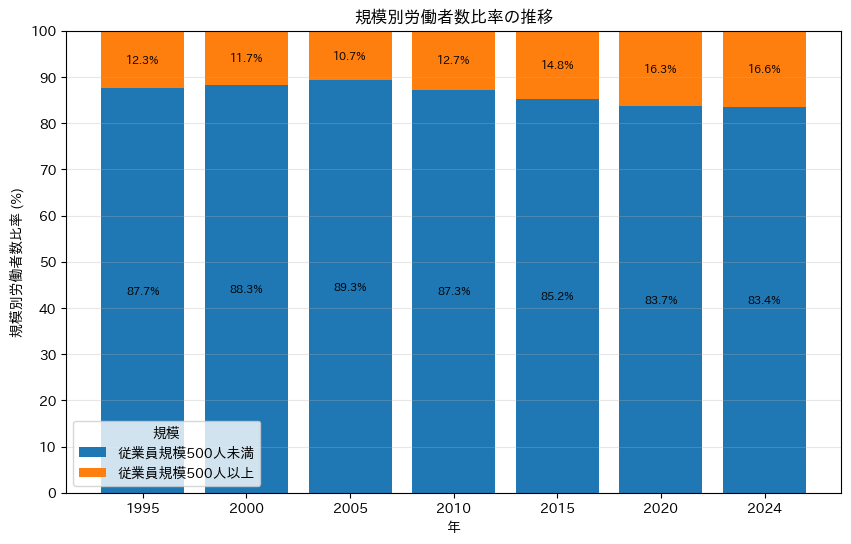

In [7]:
# 5年刻み（西暦が5で割り切れる年）と2024年のデータを抽出
target_years = sorted(list(set([y for y in tl_wages["年"].unique() if y % 5 == 0] + [2024])))
filtered_wages = tl_wages[tl_wages["年"].isin(target_years)].copy()

# 各年の規模別労働者数比率を、帯グラフとしてプロット
plt.figure(figsize=(10, 6))
sizes = ["M", "4"]
# 凡例用のラベルマッピング
label_map = {
    "M": "従業員規模500人未満",
    "4": "従業員規模500人以上"
}
bottom = np.zeros(len(target_years))
x_positions = range(len(target_years))

for size in sizes:
    size_data = filtered_wages[filtered_wages["規模"] == size]
    # 年でソート
    size_data = size_data.sort_values("年")
    
    plt.bar(x_positions, size_data["規模別労働者数比率"], bottom=bottom, label=label_map[size], width=0.8)
    
    # 各バーに比率を表示
    for x, y, val in zip(x_positions, bottom + size_data["規模別労働者数比率"] / 2, size_data["規模別労働者数比率"]):
        if val > 3.0:  # 3%以上の場合のみ表示
            plt.text(x, y, f"{val:.1f}%", ha='center', va='center', color='black', fontsize=8)

    bottom += size_data["規模別労働者数比率"].values # type: ignore

plt.xlabel("年")
plt.ylabel("規模別労働者数比率 (%)")
plt.title("規模別労働者数比率の推移")
plt.legend(title="規模")
plt.ylim(0, 100)
# y軸のグリッド間隔を10に設定
plt.yticks(np.arange(0, 101, 10))
plt.grid(axis='y', alpha=0.3)
plt.xticks(x_positions, target_years) # x軸のラベルを設定
plt.show()

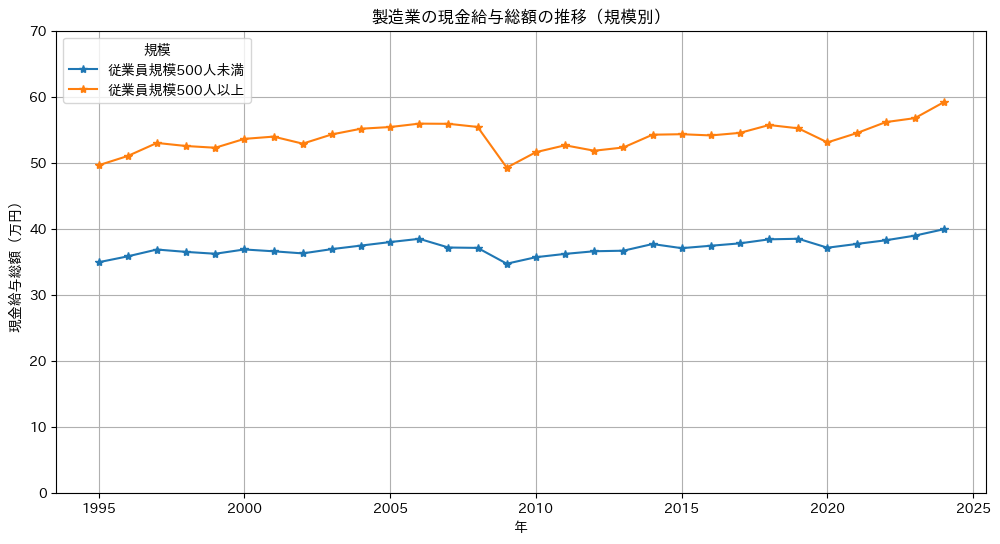

In [20]:
# 製造業（産業分類：E）について、現金給与総額を、規模"M"と"4"ごとにプロット
e_wages = all_wages[all_wages["産業分類"] == "E"]
plt.figure(figsize=(12, 6))
for size in ["M", "4"]:
    size_data = e_wages[e_wages["規模"] == size]
    plt.plot(size_data["年"], size_data["現金給与総額"] / 10000, marker='*', label=label_map[size])
plt.xlabel("年")
plt.ylabel("現金給与総額（万円）")
plt.ylim(0, 70)
plt.title("製造業の現金給与総額の推移（規模別）")
plt.legend(title="規模")
plt.grid(True)
plt.show()

In [ ]:
# 製造業の給与について、規模による有意差があるか検定
# ノンパラメトリックなので、マン・ホイットニーのU検定を使用
from scipy import stats
wages_m = e_wages[e_wages["規模"] == "M"]["現金給与総額"]
wages_4 = e_wages[e_wages["規模"] == "4"]["現金給与総額"]
u_stat, p_value = stats.mannwhitneyu(wages_m, wages_4, alternative='two-sided')
print(f"マン・ホイットニーU検定の結果: U値 = {u_stat:.3f}, p値 = {p_value:.5f}")

マン・ホイットニーU検定の結果: U値 = 0.000, p値 = 0.00000


In [67]:
# Cohenのdを計算
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std
d_value = cohen_d(wages_m, wages_4)
print(f"Cohenのd: d値 = {d_value:.3f}")

Cohenのd: d値 = -9.823


- p < 0.05 なので、有意差あり

##### 大企業の場合

In [39]:
all_wages = pd.read_csv('./data/maikin/fulltime_emp.csv', encoding='utf_8_sig', low_memory=False)
all_wages = all_wages[["年", "規模", "産業分類", "本月末労働者数", "増加労働者数", "減少労働者数", "現金給与総額", "きまって支給する給与", "所定内給与", "所定外給与", "特別給与", "所定内労働時間", "所定外労働時間"]]
all_wages = all_wages.rename(columns={
    "本月末労働者数": "労働者数",
})
all_wages.head()

,年,規模,産業分類,労働者数,増加労働者数,減少労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間
0,1995,4,C,6964.0,80.0,102.0,521444.000000,408215.000000,328758.000000,79457.000000,113229.000000,168.600000,36.600000
1,1995,M,C,57159.0,584.0,654.0,387615.333333,302702.000000,282563.333333,20138.666667,84913.333333,162.566667,10.533333
2,1995,T,C,64123.0,664.0,756.0,374611.000000,301852.000000,276967.000000,24885.000000,72759.000000,167.400000,13.200000
3,1995,4,D,157883.0,1378.0,1675.0,642039.000000,449082.000000,414135.000000,34947.000000,192957.000000,154.300000,15.800000
4,1995,M,D,3763572.0,70848.0,72909.0,419254.333333,333122.666667,313619.666667,19503.000000,86131.666667,162.500000,11.233333


In [40]:
# 規模"4"（大企業）のみを抽出
wages_4 = all_wages[all_wages["規模"] == "4"]
wages_4 = wages_4.drop(columns=["規模"])
wages_4.head()

,年,産業分類,労働者数,増加労働者数,減少労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間
0,1995,C,6964.0,80.0,102.0,521444.0,408215.0,328758.0,79457.0,113229.0,168.6,36.6
3,1995,D,157883.0,1378.0,1675.0,642039.0,449082.0,414135.0,34947.0,192957.0,154.3,15.8
6,1995,E,2549247.0,18176.0,24870.0,496154.0,359119.0,318144.0,40975.0,137035.0,148.5,15.2
9,1995,F,41085.0,462.0,497.0,648319.0,458353.0,406589.0,51764.0,189966.0,148.9,14.4
12,1995,TL,4283617.0,38898.0,48734.0,526387.0,378153.0,340780.0,37373.0,148234.0,148.8,14.0


In [41]:
# 製造業の傾向を調査する
# 産業分類"e"のデータのみを抽出
wages_4_e = wages_4[wages_4["産業分類"] == "E"]
wages_4_e = wages_4_e.drop(columns=["産業分類"])
wages_4_e.head()

,年,労働者数,増加労働者数,減少労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間
6,1995,2549247.0,18176.0,24870.0,496154.0,359119.0,318144.0,40975.0,137035.0,148.5,15.2
21,1996,2474476.0,19097.0,24471.0,510211.0,370595.0,325038.0,45557.0,139616.0,147.9,16.8
35,1997,2426426.0,20882.0,24371.0,529972.0,382708.0,332176.0,50532.0,147264.0,147.4,18.4
49,1998,2387878.0,19866.0,23697.0,525309.0,382648.0,337465.0,45183.0,142661.0,147.7,16.0
63,1999,2259709.0,17994.0,24425.0,522694.0,385786.0,341505.0,44281.0,136908.0,147.1,15.5


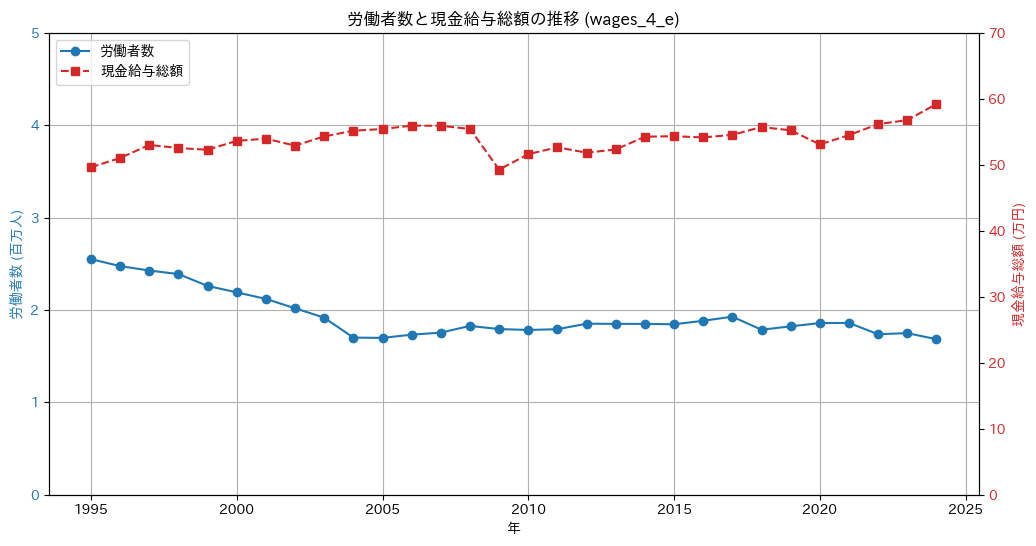

In [54]:
# 労働者数と現金給与総額を、2軸の折れ線グラフでプロット
fig, ax1 = plt.subplots(figsize=(12, 6))

# 労働者数 (左軸)
color = 'tab:blue'
ax1.set_xlabel('年')
ax1.set_ylabel('労働者数 (百万人)', color=color)
ax1.plot(wages_4_e["年"], wages_4_e["労働者数"] / 1000000, color=color, label="労働者数", marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.set_ylim(0, 5)

# 所定内給与 (右軸)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('現金給与総額 (万円)', color=color)
ax2.plot(wages_4_e["年"], wages_4_e["現金給与総額"] / 10000, color=color, label="現金給与総額", marker='s', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 70)

# タイトル
plt.title("労働者数と現金給与総額の推移 (wages_4_e)")

# 凡例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

In [42]:
# 列"年"以外について、列"労働者数"との相関係数を調査する。

# まず、それぞれの列を標準化する。
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
wages_4_e_scaled = wages_4_e.copy()
wages_4_e_scaled.iloc[:, 1:] = scaler.fit_transform(wages_4_e_scaled.iloc[:, 1:])
wages_4_e_scaled.head()

,年,労働者数,増加労働者数,減少労働者数,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,所定内労働時間,所定外労働時間
6,1995,2.495556,0.715285,1.688419,-2.042894,-2.779770,-2.707185,-1.705518,-0.394065,1.527084,-1.466224
21,1996,2.190688,1.275787,1.574877,-1.369601,-1.961519,-2.083096,-0.845006,-0.116563,1.087986,-0.690273
35,1997,1.994772,2.362103,1.546420,-0.423101,-1.097849,-1.436919,0.089313,0.705729,0.722072,0.085678
49,1998,1.837598,1.743785,1.354621,-0.646447,-1.102127,-0.958125,-0.915244,0.210827,0.941620,-1.078248
63,1999,1.315008,0.604523,1.561786,-0.771698,-0.878384,-0.592399,-1.084642,-0.407720,0.502523,-1.320733


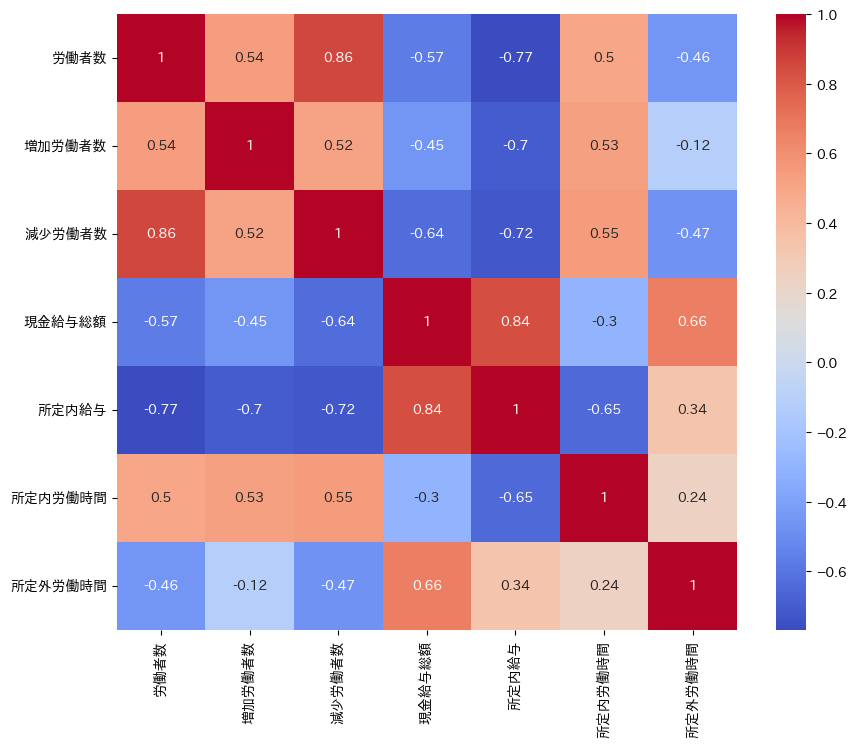

In [44]:
# wages_4_tl_scaledの列"年"を除いた各列と"労働者数"との相関係数を計算し、相関ヒートマップを作成
correlation_matrix = wages_4_e_scaled.drop(columns=["年", "きまって支給する給与", "所定外給与", "特別給与"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

In [50]:
# 有意な相関があるかを確認
from scipy.stats import pearsonr
for column in wages_4_e_scaled.columns:
    if column != "年" and column != "労働者数":
        corr_coef, p_value = pearsonr(wages_4_e_scaled["労働者数"], wages_4_e_scaled[column])
        print(f"列: {column}, 相関係数: {corr_coef:.3f}, p値: {p_value:.5f}")

列: 増加労働者数, 相関係数: 0.539, p値: 0.00210
列: 減少労働者数, 相関係数: 0.861, p値: 0.00000
列: 現金給与総額, 相関係数: -0.574, p値: 0.00092
列: きまって支給する給与, 相関係数: -0.770, p値: 0.00000
列: 所定内給与, 相関係数: -0.769, p値: 0.00000
列: 所定外給与, 相関係数: -0.433, p値: 0.01671
列: 特別給与, 相関係数: -0.127, p値: 0.50488
列: 所定内労働時間, 相関係数: 0.496, p値: 0.00533
列: 所定外労働時間, 相関係数: -0.457, p値: 0.01121


In [51]:
# 有意な相関があるかを確認
from scipy.stats import pearsonr
for column in wages_4_e_scaled.columns:
    if column != "年" and column != "増加労働者数":
        corr_coef, p_value = pearsonr(wages_4_e_scaled["増加労働者数"], wages_4_e_scaled[column])
        print(f"列: {column}, 相関係数: {corr_coef:.3f}, p値: {p_value:.5f}")

列: 労働者数, 相関係数: 0.539, p値: 0.00210
列: 減少労働者数, 相関係数: 0.516, p値: 0.00354
列: 現金給与総額, 相関係数: -0.453, p値: 0.01188
列: きまって支給する給与, 相関係数: -0.609, p値: 0.00035
列: 所定内給与, 相関係数: -0.704, p値: 0.00001
列: 所定外給与, 相関係数: -0.144, p値: 0.44868
列: 特別給与, 相関係数: -0.099, p値: 0.60223
列: 所定内労働時間, 相関係数: 0.526, p値: 0.00284
列: 所定外労働時間, 相関係数: -0.118, p値: 0.53412


In [52]:
# 有意な相関があるかを確認
from scipy.stats import pearsonr
for column in wages_4_e_scaled.columns:
    if column != "年" and column != "減少労働者数":
        corr_coef, p_value = pearsonr(wages_4_e_scaled["減少労働者数"], wages_4_e_scaled[column])
        print(f"列: {column}, 相関係数: {corr_coef:.3f}, p値: {p_value:.5f}")

列: 労働者数, 相関係数: 0.861, p値: 0.00000
列: 増加労働者数, 相関係数: 0.516, p値: 0.00354
列: 現金給与総額, 相関係数: -0.636, p値: 0.00016
列: きまって支給する給与, 相関係数: -0.723, p値: 0.00001
列: 所定内給与, 相関係数: -0.724, p値: 0.00001
列: 所定外給与, 相関係数: -0.403, p値: 0.02741
列: 特別給与, 相関係数: -0.337, p値: 0.06828
列: 所定内労働時間, 相関係数: 0.547, p値: 0.00176
列: 所定外労働時間, 相関係数: -0.469, p値: 0.00887


- 労働者数と所定内給与の間に、有意な正の相関はない。むしろ、有意な負の相関がある。

#### 非消費支出を考慮した場合

「現金給与総額」はボーナスや残業代も含むので、「所定内給与」を使用する

In [69]:
non_c = pd.read_csv("data/shotoku/non-c_raw.csv", encoding="utf-8-sig")
non_c.head()

,年,非消費支出
0,2000,53517
1,2001,51061
2,2002,56106
3,2003,53466
4,2004,52609


In [71]:
# 1995年～1999年を追加する
# 値は2000年～2004年の平均値を使用する
for year in range(1995, 2000):
    avg_values = non_c[non_c["年"].isin([2000, 2001, 2002, 2003, 2004])].mean(numeric_only=True)
    avg_values["年"] = year
    non_c = pd.concat([non_c, pd.DataFrame([avg_values])], ignore_index=True)
non_c = non_c.sort_values("年").reset_index(drop=True)

# 年はint型に変換する
non_c["年"] = non_c["年"].astype(int)
non_c.head()

,年,非消費支出
0,1995,53351.8
1,1995,53351.8
2,1996,53351.8
3,1996,53351.8
4,1997,53351.8


In [72]:
all_wages = pd.read_csv('./data/maikin/fulltime_emp.csv', encoding='utf_8_sig', low_memory=False)
all_wages = all_wages[["年", "規模", "産業分類", "本月末労働者数", "増加労働者数", "減少労働者数", "所定内給与", "所定内労働時間"]]
all_wages = all_wages.rename(columns={
    "本月末労働者数": "労働者数",
})
all_wages.head()

,年,規模,産業分類,労働者数,増加労働者数,減少労働者数,所定内給与,所定内労働時間
0,1995,4,C,6964.0,80.0,102.0,328758.000000,168.600000
1,1995,M,C,57159.0,584.0,654.0,282563.333333,162.566667
2,1995,T,C,64123.0,664.0,756.0,276967.000000,167.400000
3,1995,4,D,157883.0,1378.0,1675.0,414135.000000,154.300000
4,1995,M,D,3763572.0,70848.0,72909.0,313619.666667,162.500000


In [73]:
# 規模が"4"、産業分類が"E"のデータのみを抽出
wages_4_e = all_wages[(all_wages["規模"] == "4") & (all_wages["産業分類"] == "E")]
wages_4_e = wages_4_e.drop(columns=["規模", "産業分類"])

# non_cとwages_4_eを年で結合する
wages_4_e = pd.merge(wages_4_e, non_c, on="年", how="left")
wages_4_e.head()

,年,労働者数,増加労働者数,減少労働者数,所定内給与,所定内労働時間,非消費支出
0,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8
1,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8
2,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8
3,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8
4,1997,2426426.0,20882.0,24371.0,332176.0,147.4,53351.8


In [74]:
# 可処分所得を計算
wages_4_e["可処分所得"] = wages_4_e["所定内給与"] - wages_4_e["非消費支出"]
wages_4_e.head()

,年,労働者数,増加労働者数,減少労働者数,所定内給与,所定内労働時間,非消費支出,可処分所得
0,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8,264792.2
1,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8,264792.2
2,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8,271686.2
3,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8,271686.2
4,1997,2426426.0,20882.0,24371.0,332176.0,147.4,53351.8,278824.2


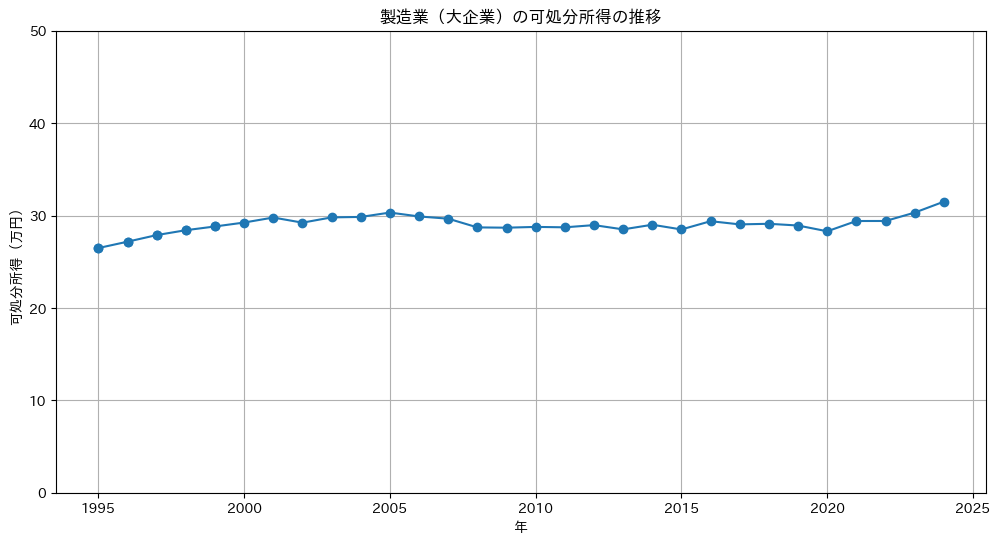

In [76]:
# 可処分所得の推移をプロット
plt.figure(figsize=(12, 6))
plt.plot(wages_4_e["年"], wages_4_e["可処分所得"] / 10000, marker='o')
plt.xlabel("年")
plt.ylim(0, 50)
plt.ylabel("可処分所得（万円）")
plt.title("製造業（大企業）の可処分所得の推移")
plt.grid(True)
plt.show()

- 30年間であまり変わっていない
    - 物価の上昇率を考慮したらどうなるか？

##### 消費者物価指数を考慮した場合

In [79]:
cpi_data = pd.read_csv('./data/bukka/bukka-index_cleaned.csv', encoding='utf-8-sig', low_memory=False)
cpi_data.head()

,年,総合,食料,住居,光熱・水道,家具・家事用品,被服及び履物,保健医療,交通・通信,教育,...,情報通信関係費,財,生鮮食品を除く財,米類,サービス,持家の帰属家賃を除くサービス,耐久消費財,半耐久消費財,非耐久消費財,公共料金
0,1995,95.9,86.5,98.1,81.0,146.2,94.6,85.6,103.2,100.6,...,NaN,97.3,99.3,119.2,94.4,92.6,205.3,96.7,87.5,91.2
1,1996,96.3,86.9,99.4,81.8,143.1,95.7,86.2,102.2,102.7,...,NaN,97.0,98.8,117.3,95.3,93.4,197.6,97.0,87.6,91.7
2,1997,98.2,88.8,100.9,85.3,142.5,98.4,92.7,102.3,105.0,...,NaN,98.7,100.6,114.4,97.6,96.0,196.6,99.1,89.2,94.4
3,1998,98.4,89.7,101.1,83.2,140.2,99.1,96.3,100.5,106.8,...,NaN,98.6,99.8,112.8,98.1,96.4,192.6,99.4,89.2,94.2
4,1999,97.9,88.7,101.2,82.4,137.9,98.8,95.3,100.7,108.2,...,NaN,97.6,99.4,112.2,98.2,96.4,189.3,98.9,88.3,93.5


In [80]:
# 列名を確認
cpi_data.columns

Index(['年', '総合', '食料', '住居', '光熱・水道', '家具・家事用品', '被服及び履物', '保健医療', '交通・通信',
       '教育', '教養娯楽', '諸雑費', '生鮮食品', '生鮮食品を除く総合', '生鮮食品を除く食料', '持家の帰属家賃を除く総合',
       '持家の帰属家賃を除く住居', '持家の帰属家賃を除く家賃', '持家の帰属家賃及び生鮮食品を除く総合', 'エネルギー',
       '生鮮食品及びエネルギーを除く総合', '食料（酒類を除く）及びエネルギーを除く総合', '教育関係費', '教養娯楽関係費',
       '情報通信関係費', '財', '生鮮食品を除く財', '米類', 'サービス', '持家の帰属家賃を除くサービス', '耐久消費財',
       '半耐久消費財', '非耐久消費財', '公共料金'],
      dtype='object')

In [82]:
cpi_data.isna().sum()

年                         0
総合                        0
食料                        0
住居                        0
光熱・水道                     0
家具・家事用品                   0
被服及び履物                    0
保健医療                      0
交通・通信                     0
教育                        0
教養娯楽                      0
諸雑費                       0
生鮮食品                      0
生鮮食品を除く総合                 0
生鮮食品を除く食料                 0
持家の帰属家賃を除く総合              0
持家の帰属家賃を除く住居              0
持家の帰属家賃を除く家賃              0
持家の帰属家賃及び生鮮食品を除く総合        0
エネルギー                     0
生鮮食品及びエネルギーを除く総合          0
食料（酒類を除く）及びエネルギーを除く総合     0
教育関係費                     0
教養娯楽関係費                   0
情報通信関係費                  10
財                         0
生鮮食品を除く財                  0
米類                        0
サービス                      0
持家の帰属家賃を除くサービス            0
耐久消費財                     0
半耐久消費財                    0
非耐久消費財                    0
公共料金                      0
dtype: int64

In [86]:
cpi_to_use = cpi_data[["年", "総合", "食料", "米類", "生鮮食品", "住居", "光熱・水道", "公共料金", "エネルギー", "保健医療"]]
cpi_to_use.head()

,年,総合,食料,米類,生鮮食品,住居,光熱・水道,公共料金,エネルギー,保健医療
0,1995,95.9,86.5,119.2,78.9,98.1,81.0,91.2,83.1,85.6
1,1996,96.3,86.9,117.3,80.5,99.4,81.8,91.7,82.1,86.2
2,1997,98.2,88.8,114.4,81.5,100.9,85.3,94.4,83.9,92.7
3,1998,98.4,89.7,112.8,86.5,101.1,83.2,94.2,79.8,96.3
4,1999,97.9,88.7,112.2,80.3,101.2,82.4,93.5,79.6,95.3


In [87]:
# wages_4_e と cpi_to_use を"年"で結合
wages_4e_and_cpi = pd.merge(wages_4_e, cpi_to_use, on="年", how="left")
wages_4e_and_cpi.head()

,年,労働者数,増加労働者数,減少労働者数,所定内給与,所定内労働時間,非消費支出,可処分所得,総合,食料,米類,生鮮食品,住居,光熱・水道,公共料金,エネルギー,保健医療
0,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8,264792.2,95.9,86.5,119.2,78.9,98.1,81.0,91.2,83.1,85.6
1,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8,264792.2,95.9,86.5,119.2,78.9,98.1,81.0,91.2,83.1,85.6
2,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8,271686.2,96.3,86.9,117.3,80.5,99.4,81.8,91.7,82.1,86.2
3,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8,271686.2,96.3,86.9,117.3,80.5,99.4,81.8,91.7,82.1,86.2
4,1997,2426426.0,20882.0,24371.0,332176.0,147.4,53351.8,278824.2,98.2,88.8,114.4,81.5,100.9,85.3,94.4,83.9,92.7


In [88]:
# 所定内給与、非消費支出、可処分所得について、2020年を基準とした指数に変換する
base_year = 2020
for col in ["所定内給与", "非消費支出", "可処分所得"]:
    base_value = wages_4e_and_cpi[wages_4e_and_cpi["年"] == base_year][col].values[0]
    wages_4e_and_cpi[f"{col}_指数"] = round((wages_4e_and_cpi[col] / base_value) * 100, 1)
wages_4e_and_cpi.head()

,年,労働者数,増加労働者数,減少労働者数,所定内給与,所定内労働時間,非消費支出,可処分所得,総合,食料,米類,生鮮食品,住居,光熱・水道,公共料金,エネルギー,保健医療,所定内給与_指数,非消費支出_指数,可処分所得_指数
0,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8,264792.2,95.9,86.5,119.2,78.9,98.1,81.0,91.2,83.1,85.6,90.1,76.0,93.6
1,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8,264792.2,95.9,86.5,119.2,78.9,98.1,81.0,91.2,83.1,85.6,90.1,76.0,93.6
2,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8,271686.2,96.3,86.9,117.3,80.5,99.4,81.8,91.7,82.1,86.2,92.0,76.0,96.0
3,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8,271686.2,96.3,86.9,117.3,80.5,99.4,81.8,91.7,82.1,86.2,92.0,76.0,96.0
4,1997,2426426.0,20882.0,24371.0,332176.0,147.4,53351.8,278824.2,98.2,88.8,114.4,81.5,100.9,85.3,94.4,83.9,92.7,94.1,76.0,98.5


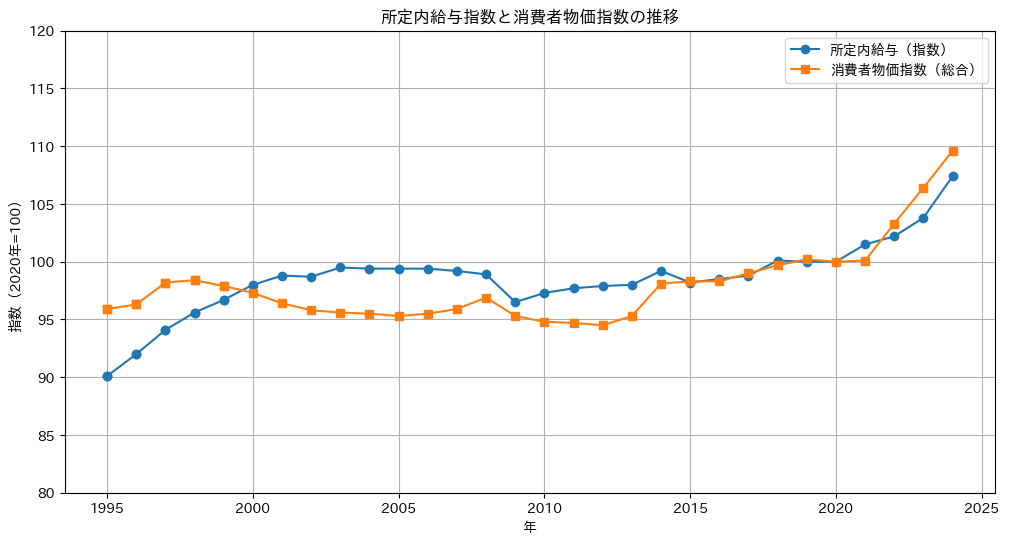

In [90]:
# "所定内給与_指数" と "総合"（消費者物価指数）をプロットして比較する
plt.figure(figsize=(12, 6))
plt.plot(wages_4e_and_cpi["年"], wages_4e_and_cpi["所定内給与_指数"], marker='o', label="所定内給与（指数）")
plt.plot(wages_4e_and_cpi["年"], wages_4e_and_cpi["総合"], marker='s', label="消費者物価指数（総合）")
plt.xlabel("年")
plt.ylim(80, 120)
plt.ylabel("指数（2020年=100）")
plt.grid(True)
plt.title("所定内給与指数と消費者物価指数の推移")
plt.legend()
plt.show()

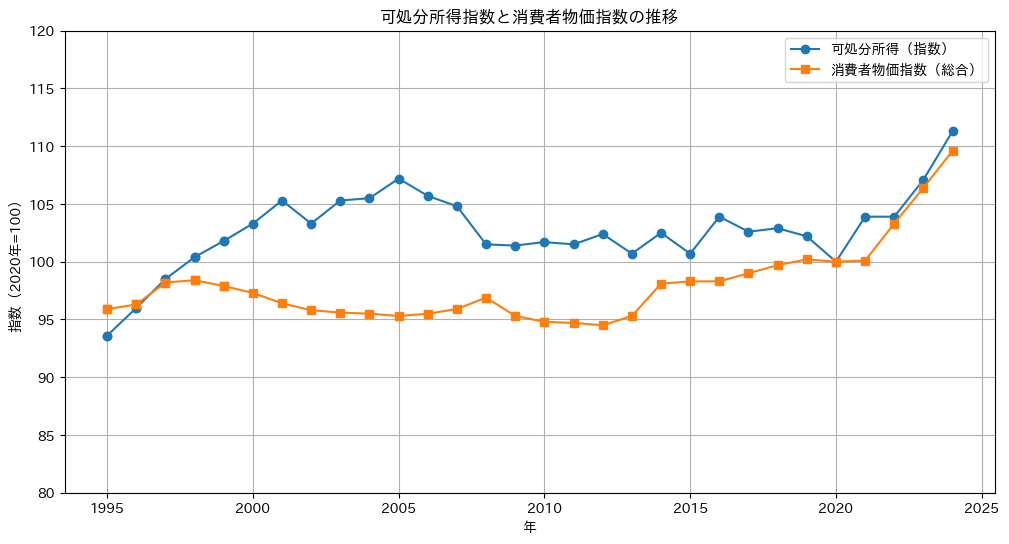

In [94]:
# 可処分所得 と 総合（消費者物価指数）をプロットして比較する
plt.figure(figsize=(12, 6))
plt.plot(wages_4e_and_cpi["年"], wages_4e_and_cpi["可処分所得_指数"], marker='o', label="可処分所得（指数）")
plt.plot(wages_4e_and_cpi["年"], wages_4e_and_cpi["総合"], marker='s', label="消費者物価指数（総合）")
plt.xlabel("年")
plt.ylim(80, 120)
plt.ylabel("指数（2020年=100）")
plt.grid(True)
plt.title("可処分所得指数と消費者物価指数の推移")
plt.legend()
plt.show()

- 2020年まで、消費者物価指数を上回っている
    - 差が小さくなっているのは事実

In [95]:
# 全ての指数を、1995年基準に変換してみる
base_year = 1995
for col in ["所定内給与", "非消費支出", "可処分所得", "総合", "食料", "米類", "生鮮食品", "住居", "光熱・水道", "公共料金", "エネルギー", "保健医療"]:
    base_value = wages_4e_and_cpi[wages_4e_and_cpi["年"] == base_year][col].values[0]
    wages_4e_and_cpi[f"{col}_指数_1995基準"] = round((wages_4e_and_cpi[col] / base_value) * 100, 1)
wages_4e_and_cpi.head()

,年,労働者数,増加労働者数,減少労働者数,所定内給与,所定内労働時間,非消費支出,可処分所得,総合,食料,...,可処分所得_指数_1995基準,総合_指数_1995基準,食料_指数_1995基準,米類_指数_1995基準,生鮮食品_指数_1995基準,住居_指数_1995基準,光熱・水道_指数_1995基準,公共料金_指数_1995基準,エネルギー_指数_1995基準,保健医療_指数_1995基準
0,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8,264792.2,95.9,86.5,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,1995,2549247.0,18176.0,24870.0,318144.0,148.5,53351.8,264792.2,95.9,86.5,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8,271686.2,96.3,86.9,...,102.6,100.4,100.5,98.4,102.0,101.3,101.0,100.5,98.8,100.7
3,1996,2474476.0,19097.0,24471.0,325038.0,147.9,53351.8,271686.2,96.3,86.9,...,102.6,100.4,100.5,98.4,102.0,101.3,101.0,100.5,98.8,100.7
4,1997,2426426.0,20882.0,24371.0,332176.0,147.4,53351.8,278824.2,98.2,88.8,...,105.3,102.4,102.7,96.0,103.3,102.9,105.3,103.5,101.0,108.3


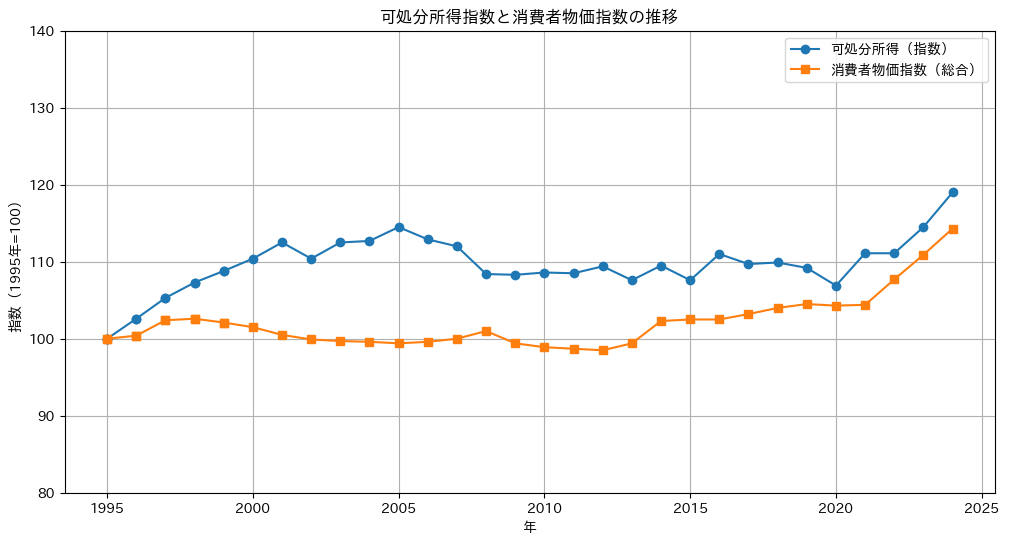

In [97]:
# 可処分所得 と 総合（消費者物価指数）をプロットして比較する
plt.figure(figsize=(12, 6))
plt.plot(wages_4e_and_cpi["年"], wages_4e_and_cpi["可処分所得_指数_1995基準"], marker='o', label="可処分所得（指数）")
plt.plot(wages_4e_and_cpi["年"], wages_4e_and_cpi["総合_指数_1995基準"], marker='s', label="消費者物価指数（総合）")
plt.xlabel("年")
plt.ylim(80, 140)
plt.ylabel("指数（1995年=100）")
plt.grid(True)
plt.title("可処分所得指数と消費者物価指数の推移")
plt.legend()
plt.show()

- 1995年と同じ水準に近づいてはいる？

### 1995年（30年前）を基準とした雇用指数

In [29]:
all_employees = all_data[["年","月","産業分類", "規模", "就業形態", "現金給与総額","本月末労働者数","パートタイム労働者数"]]
all_employees.head()

,年,月,産業分類,規模,就業形態,現金給与総額,本月末労働者数,パートタイム労働者数
0,1960,CY,C,0,0,26250,NaN,NaN
1,1960,CY,C,4,0,28786,NaN,NaN
2,1960,CY,C,5,0,22422,NaN,NaN
3,1960,CY,C,7,0,18826,NaN,NaN
4,1960,CY,D,0,0,21213,NaN,NaN


In [30]:
# 月 = CY のみのデータを抽出
all_employees = all_employees[all_employees["月"] == "CY"]

In [31]:
# 産業分類が細かくなっているものを、統一（例：E12 => E）
all_employees["産業分類"] = all_employees["産業分類"].str.slice(0,1)
all_employees["産業分類"].unique()

array(['C', 'D', 'E', 'F', 'T', 'H', 'I', 'J', 'M', 'L', 'R', 'G', 'K',
       'O', 'P', 'Q', 'N'], dtype=object)

In [32]:
# 数値列を数値型に変換
all_employees["現金給与総額"] = pd.to_numeric(all_employees["現金給与総額"], errors='coerce')
all_employees["本月末労働者数"] = pd.to_numeric(all_employees["本月末労働者数"], errors='coerce')
all_employees["パートタイム労働者数"] = pd.to_numeric(all_employees["パートタイム労働者数"], errors='coerce')
all_employees["規模"] = pd.to_numeric(all_employees["規模"], errors='coerce')

# 規模ごとに分かれているデータを、平均して統一
all_employees = all_employees.groupby(["年", "月", "産業分類", "就業形態"]).mean(numeric_only=True).reset_index()
all_employees.head()

,年,月,産業分類,就業形態,規模,現金給与総額,本月末労働者数,パートタイム労働者数
0,1960,CY,C,0,4.0,24071.00,NaN,NaN
1,1960,CY,D,0,4.0,21433.25,NaN,NaN
2,1960,CY,E,0,4.0,22637.30,NaN,NaN
3,1960,CY,F,0,4.0,36734.00,NaN,NaN
4,1961,CY,C,0,4.0,26290.75,NaN,NaN


In [33]:
# 就業形態が0（全形態）のみを抽出
all_employees = all_employees[all_employees["就業形態"] == 0]

# 不要な列をドロップ
all_employees = all_employees.drop(columns=["月","規模","就業形態"])

In [34]:
# 本月末労働者数とパートタイム労働者数を、小数点以下切り上げ
all_employees["本月末労働者数"] = np.ceil(all_employees["本月末労働者数"])
all_employees["パートタイム労働者数"] = np.ceil(all_employees["パートタイム労働者数"])

In [35]:
# 1995年以降のデータを抽出
all_employees = all_employees[all_employees["年"] >= 1995]

In [36]:
# 1995年の本月末労働者数を基準に、各年の労働者数を各産業ごとに指数化（小数点第3位まで）
all_employees = all_employees.merge(
    all_employees[all_employees["年"] == 1995][["産業分類", "本月末労働者数"]].rename(columns={"本月末労働者数": "基準労働者数"}),
    on="産業分類",
    how="left"
)
all_employees["労働者数指数"] = round(all_employees["本月末労働者数"] / all_employees["基準労働者数"], 3)
all_employees.head()

,年,産業分類,現金給与総額,本月末労働者数,パートタイム労働者数,基準労働者数,労働者数指数
0,1995,C,411388.500000,26535.0,710.0,26535.0,1.0
1,1995,D,429623.083333,1259773.0,41194.0,1259773.0,1.0
2,1995,E,370957.833333,681414.0,59752.0,681414.0,1.0
3,1995,F,577502.375000,153320.0,2238.0,153320.0,1.0
4,1995,H,429780.000000,621037.0,31483.0,621037.0,1.0


In [44]:
# 1995年の現金給与総額を基準に、各年の賃金を各産業ごとに指数化（小数点第3位まで）
all_employees = all_employees.merge(
    all_employees[all_employees["年"] == 1995][["産業分類", "現金給与総額"]].rename(columns={"現金給与総額": "基準現金給与総額"}),
    on="産業分類",
    how="left"
)
all_employees["現金給与総額指数"] = round(all_employees["現金給与総額"] / all_employees["基準現金給与総額"], 3)
all_employees.head()

,年,産業分類,現金給与総額,本月末労働者数,パートタイム労働者数,基準労働者数,労働者数指数,基準現金給与総額,現金給与総額指数
0,1995,C,411388.500000,26535.0,710.0,26535.0,1.0,411388.500000,1.0
1,1995,D,429623.083333,1259773.0,41194.0,1259773.0,1.0,429623.083333,1.0
2,1995,E,370957.833333,681414.0,59752.0,681414.0,1.0,370957.833333,1.0
3,1995,F,577502.375000,153320.0,2238.0,153320.0,1.0,577502.375000,1.0
4,1995,H,429780.000000,621037.0,31483.0,621037.0,1.0,429780.000000,1.0


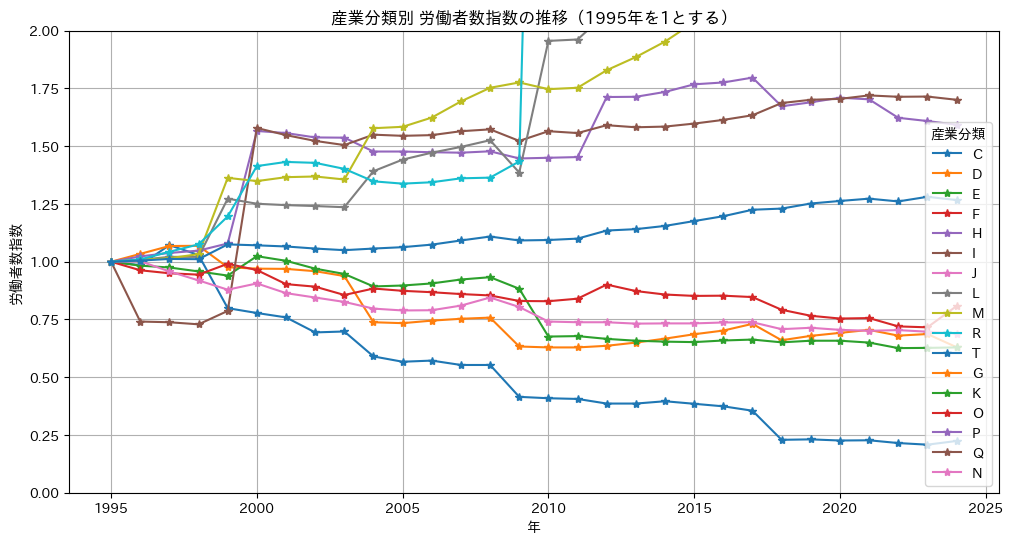

In [47]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in all_employees["産業分類"].unique():
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["労働者数指数"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("労働者数指数")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 労働者数指数の推移（1995年を1とする）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

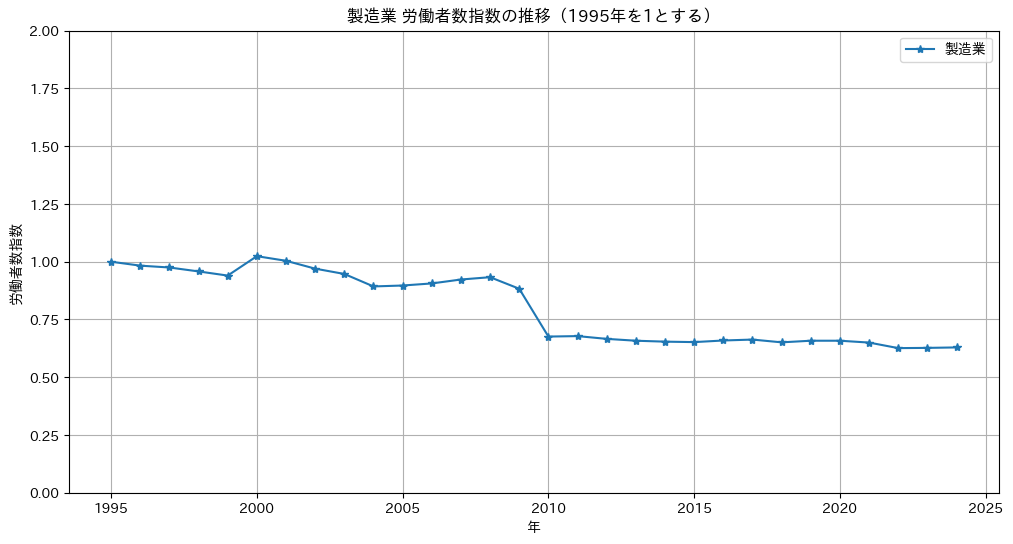

In [45]:
# 産業分類E（製造業）のみを抽出
e_employees = all_employees[all_employees["産業分類"] == "E"]

# グラフ化
plt.figure(figsize=(12, 6))
plt.plot(e_employees["年"], e_employees["労働者数指数"], marker='*', label="製造業")
plt.xlabel("年")
plt.ylabel("労働者数指数")
plt.ylim(0.0, 2.0)
plt.title("製造業 労働者数指数の推移（1995年を1とする）")
plt.legend()
plt.grid(True)
plt.show()

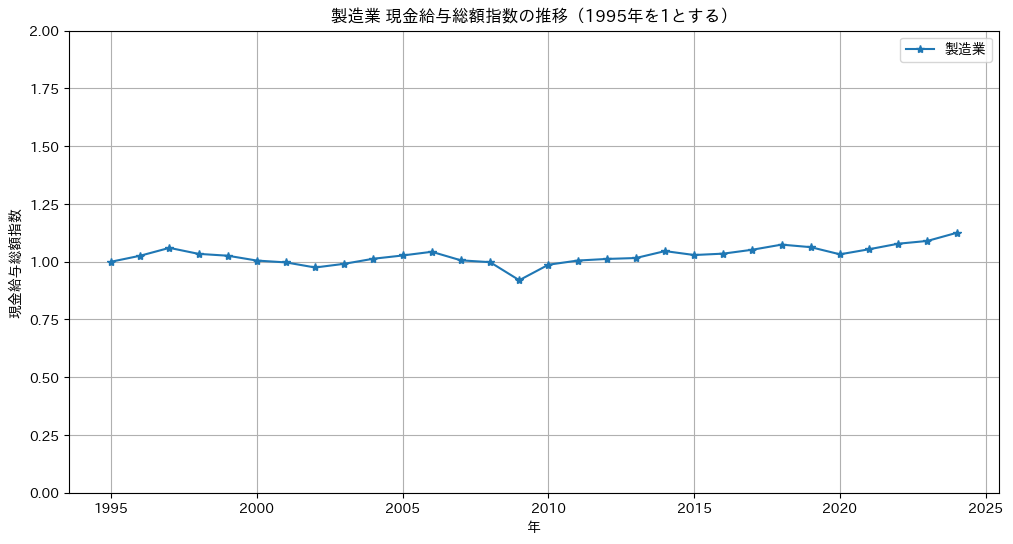

In [46]:
# 産業分類E（製造業）のみを抽出
e_employees = all_employees[all_employees["産業分類"] == "E"]

# グラフ化
plt.figure(figsize=(12, 6))
plt.plot(e_employees["年"], e_employees["現金給与総額指数"], marker='*', label="製造業")
plt.xlabel("年")
plt.ylabel("現金給与総額指数")
plt.ylim(0.0, 2.0)
plt.title("製造業 現金給与総額指数の推移（1995年を1とする）")
plt.legend()
plt.grid(True)
plt.show()

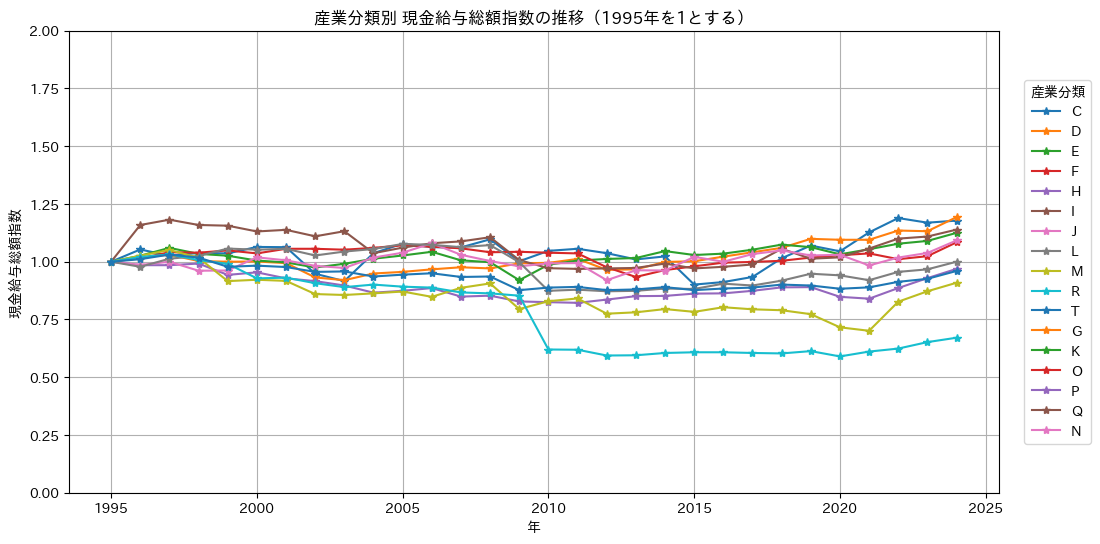

In [50]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in all_employees["産業分類"].unique():
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["現金給与総額指数"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("現金給与総額指数")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 現金給与総額指数の推移（1995年を1とする）")
plt.legend(title="産業分類", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

In [51]:
# 現金給与総額指数の、対製造業を計算
all_employees["現金給与総額指数対製造業"] = all_employees.apply(lambda row: round(row["現金給与総額指数"] / all_employees[(all_employees["年"] == row["年"]) & (all_employees["産業分類"] == "E")]["現金給与総額指数"].values[0], 3), axis=1)
all_employees.head()

,年,産業分類,現金給与総額,本月末労働者数,パートタイム労働者数,基準労働者数,労働者数指数,基準現金給与総額,現金給与総額指数,現金給与総額指数対製造業
0,1995,C,411388.500000,26535.0,710.0,26535.0,1.0,411388.500000,1.0,1.0
1,1995,D,429623.083333,1259773.0,41194.0,1259773.0,1.0,429623.083333,1.0,1.0
2,1995,E,370957.833333,681414.0,59752.0,681414.0,1.0,370957.833333,1.0,1.0
3,1995,F,577502.375000,153320.0,2238.0,153320.0,1.0,577502.375000,1.0,1.0
4,1995,H,429780.000000,621037.0,31483.0,621037.0,1.0,429780.000000,1.0,1.0


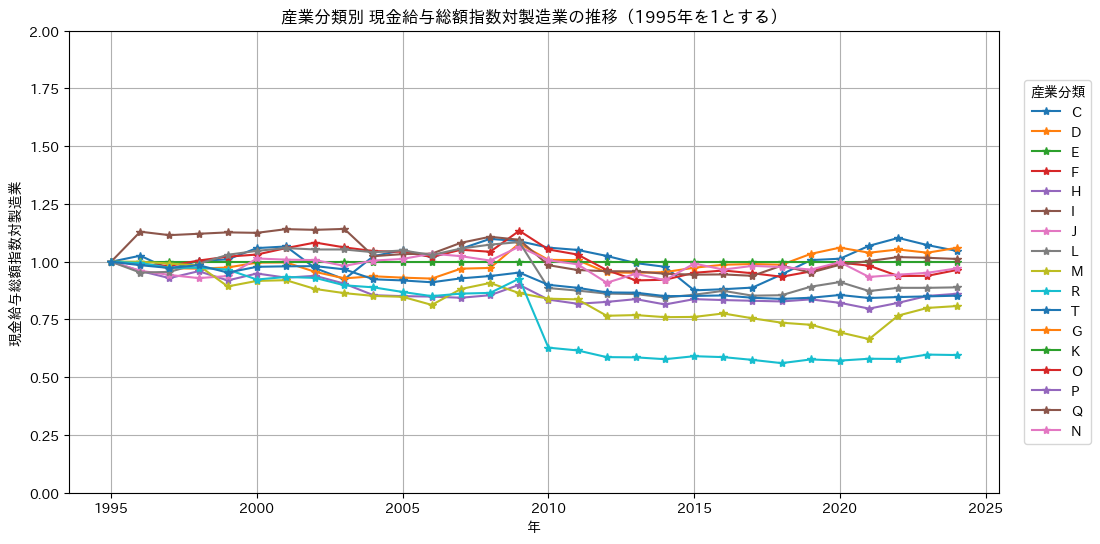

In [52]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in all_employees["産業分類"].unique():
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["現金給与総額指数対製造業"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("現金給与総額指数対製造業")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 現金給与総額指数対製造業の推移（1995年を1とする）")
plt.legend(title="産業分類", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

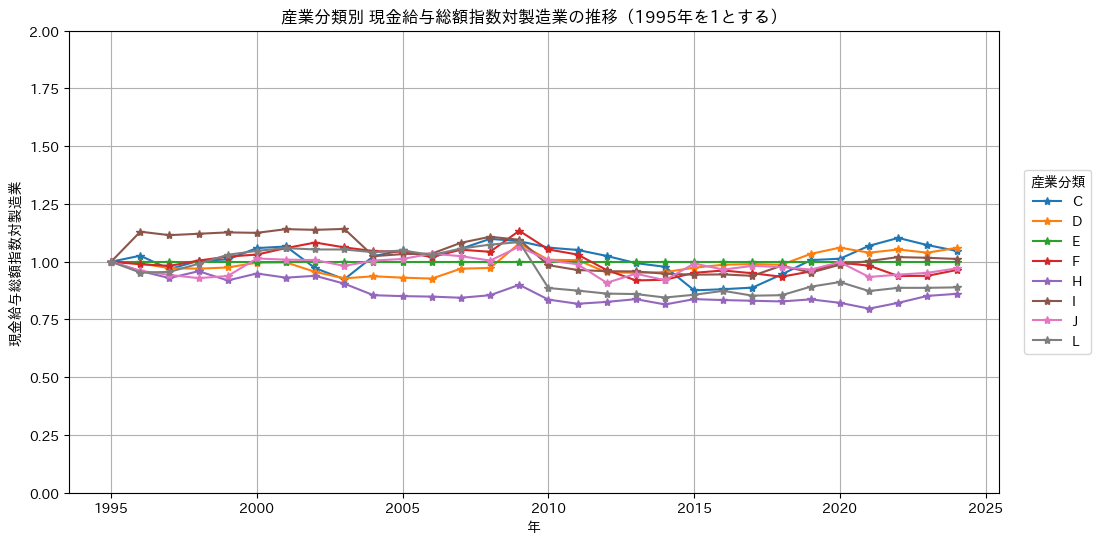

In [54]:
# 多すぎるので、産業分類カテゴリの半分ずつプロット
industries = all_employees["産業分類"].unique()
mid_index = len(industries) // 2
plt.figure(figsize=(12, 6))
for industry in industries[:mid_index]:
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["現金給与総額指数対製造業"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("現金給与総額指数対製造業")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 現金給与総額指数対製造業の推移（1995年を1とする）")
plt.legend(title="産業分類", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

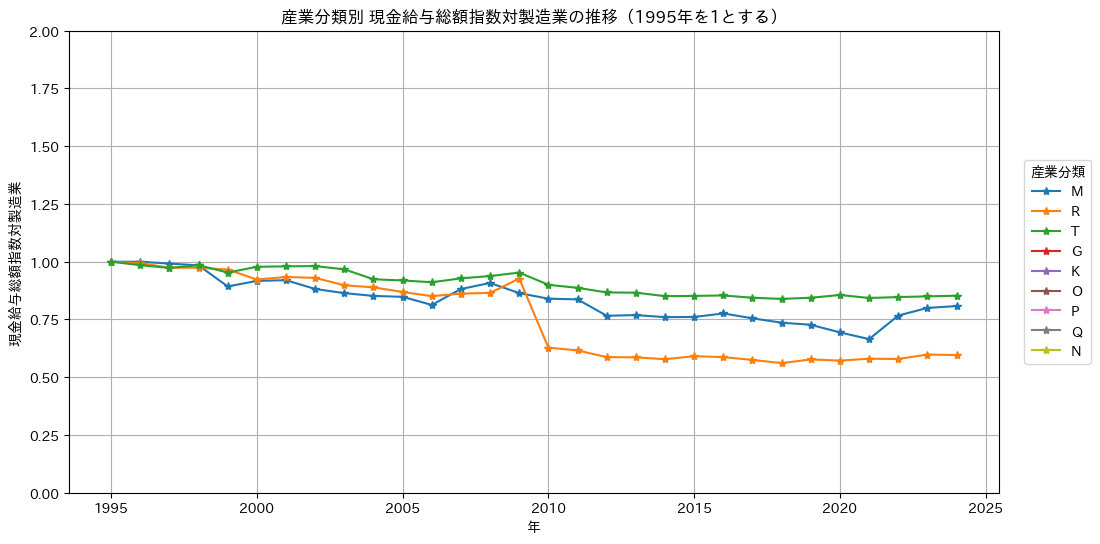

In [55]:
# もう半分をプロット
plt.figure(figsize=(12, 6))
for industry in industries[mid_index:]:
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["現金給与総額指数対製造業"], marker='*', label=industry)
plt.xlabel("年")
plt.ylabel("現金給与総額指数対製造業")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 現金給与総額指数対製造業の推移（1995年を1とする）")
plt.legend(title="産業分類", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

### 雇用者数の割合

In [11]:
employees_data = all_data[["年","産業分類","本月末労働者数","増加労働者数","減少労働者数","パートタイム労働者数"]]

# 列をリネーム
employees_data = employees_data.rename(columns={
    "本月末労働者数": "労働者数",
    "増加労働者数": "増加労働者数",
    "減少労働者数": "減少労働者数",
})

employees_data.head()

,年,産業分類,労働者数,増加労働者数,減少労働者数,パートタイム労働者数
2662,1995,C,64123.0,664.0,756.0,NaN
2680,1995,D,3921455.0,72226.0,74583.0,NaN
2704,1995,E,9696646.0,94981.0,116329.0,NaN
2788,1995,F,320772.0,3454.0,3472.0,NaN
2832,1995,TL,34684417.0,481044.0,521868.0,NaN


In [12]:
# 各産業分類ごとに、その年の調査対象労働者数に対する労働者数割合を計算、小数点第3位まで
employees_data["労働者数割合"] = employees_data.apply(lambda row: round((row["労働者数"] / employees_data[(employees_data["年"] == row["年"]) & (employees_data["産業分類"] == "TL")]["労働者数"].values[0])*100, 3), axis=1)
employees_data.head()

,年,産業分類,労働者数,増加労働者数,減少労働者数,パートタイム労働者数,労働者数割合
2662,1995,C,64123.0,664.0,756.0,NaN,0.185
2680,1995,D,3921455.0,72226.0,74583.0,NaN,11.306
2704,1995,E,9696646.0,94981.0,116329.0,NaN,27.957
2788,1995,F,320772.0,3454.0,3472.0,NaN,0.925
2832,1995,TL,34684417.0,481044.0,521868.0,NaN,100.000


In [13]:
employees_data.to_csv('./data/maikin/employees_data.csv', encoding='utf_8_sig', index=False)

In [14]:
# 産業分類"TL"（調査産業計）のデータは、別のDataFrameに分離
t_employees_data = employees_data[employees_data["産業分類"] == "TL"]
employees_data = employees_data[employees_data["産業分類"] != "TL"]
t_employees_data.head()

,年,産業分類,労働者数,増加労働者数,減少労働者数,パートタイム労働者数,労働者数割合
2832,1995,TL,34684417.0,481044.0,521868.0,NaN,100.0
3025,1996,TL,34807220.0,494309.0,525878.0,NaN,100.0
3216,1997,TL,34875234.0,506725.0,537616.0,NaN,100.0
3407,1998,TL,34602074.0,470285.0,528309.0,NaN,100.0
3598,1999,TL,35032956.0,493899.0,537633.0,NaN,100.0


In [15]:
# 2024年時点での各産業分類の労働者数割合を取得
employees_2024 = employees_data[employees_data["年"] == 2024].groupby("産業分類")["労働者数割合"].mean().reset_index()
print("2024年の産業分類別労働者数割合:")
print(employees_2024.sort_values("労働者数割合", ascending=False))

# 1%未満の産業分類を"その他"に分類
minor_industries = employees_2024[employees_2024["労働者数割合"] < 1.0]["産業分類"].tolist()
print("\n1%未満の産業分類（その他に分類）:", minor_industries)

# 新しい産業分類列を作成
def reclassify_industry(industry):
    if industry == "E":
        return "E"  # 製造業は単独
    elif industry in minor_industries:
        return "その他"
    else:
        return industry

employees_data["産業分類_新"] = employees_data["産業分類"].apply(reclassify_industry)
print("\n新しい産業分類:")
print(employees_data["産業分類_新"].unique())

# "その他"のデータを集約
employees_data_grouped = employees_data.groupby(["年", "産業分類_新"]).agg({
    "労働者数": "sum",
    "労働者数割合": "sum",
    "増加労働者数": "sum",
    "減少労働者数": "sum",
    "パートタイム労働者数": "sum"
}).reset_index()

2024年の産業分類別労働者数割合:
   産業分類  労働者数割合
2     E  18.994
13    P  15.742
6     I  14.730
15    R   9.325
5     H   7.109
1     D   6.774
12    O   6.123
4     G   4.968
9     L   4.398
7     J   3.391
10    M   2.739
11    N   2.073
8     K   2.069
14    Q   0.812
3     F   0.719
0     C   0.035

1%未満の産業分類（その他に分類）: ['C', 'F', 'Q']

新しい産業分類:
['その他' 'D' 'E' 'G' 'H' 'I' 'J' 'O' 'P' 'K' 'L' 'M' 'N' 'R']


In [16]:
employees_data_grouped.head()

,年,産業分類_新,労働者数,労働者数割合,増加労働者数,減少労働者数,パートタイム労働者数
0,1995,D,3921455.0,11.306,72226.0,74583.0,0.0
1,1995,E,9696646.0,27.957,94981.0,116329.0,0.0
2,1995,その他,384895.0,1.110,4118.0,4228.0,0.0
3,1996,D,4068538.0,11.689,78229.0,77024.0,0.0
4,1996,E,9533723.0,27.390,94674.0,111510.0,0.0


In [17]:
import matplotlib.cm as cm

C:\Users\chika\AppData\Local\Temp\ipykernel_19700\1101237533.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('tab20', 20)
C:\Users\chika\AppData\Local\Temp\ipykernel_19700\1101237533.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap('Set3', 12)
C:\Users\chika\AppData\Local\Temp\ipykernel_19700\1101237533.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap3 = cm.get_cmap('Paired', 12)


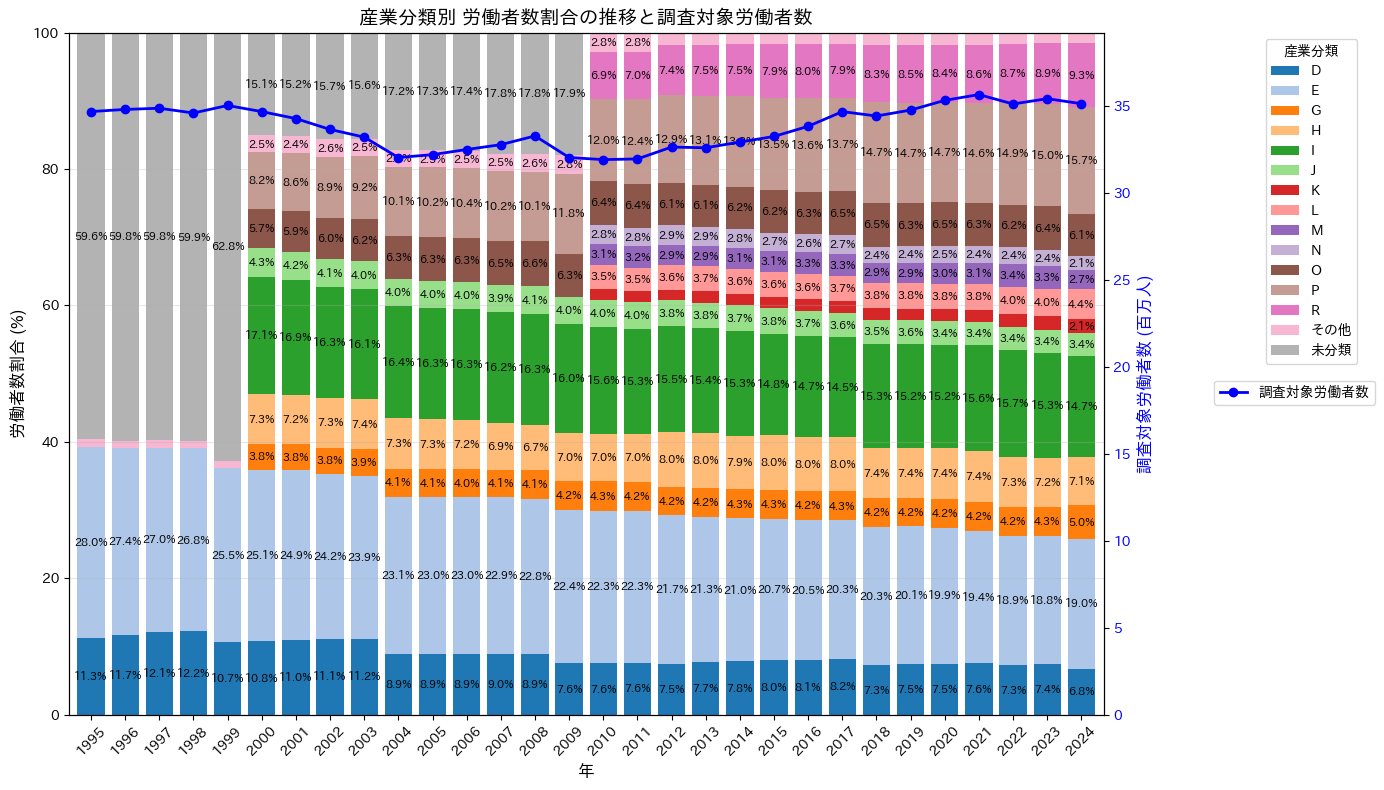

In [18]:
# ピボットテーブルを作成(年 × 産業分類_新)
pivot_data = employees_data_grouped.pivot(index="年", columns="産業分類_新", values="労働者数割合").fillna(0)

# 100%に満たない部分を「未分類」として追加
pivot_data["未分類"] = 100 - pivot_data.sum(axis=1)

# より多様な色を生成するため、複数のカラーマップを組み合わせる
n_colors = len(pivot_data.columns)

# 色のリストを作成（tab20、Set3、Pairedを組み合わせて多様性を確保）
colors = []
cmap1 = cm.get_cmap('tab20', 20)
cmap2 = cm.get_cmap('Set3', 12)
cmap3 = cm.get_cmap('Paired', 12)

for i in range(n_colors):
    if i < 20:
        colors.append(cmap1(i))
    elif i < 32:
        colors.append(cmap2(i - 20))
    else:
        colors.append(cmap3(i - 32))

# 未分類は灰色に設定
if "未分類" in pivot_data.columns:
    colors[-1] = (0.7, 0.7, 0.7, 1.0)  # グレー

# 2軸グラフを作成
fig, ax1 = plt.subplots(figsize=(14, 8))

# 帯グラフをプロット(棒グラフとして)
pivot_data.plot(kind='bar', stacked=True, ax=ax1, width=0.8, color=colors, legend=False)

# 各バーに労働者数割合の値を表示
for i, year in enumerate(pivot_data.index):
    y_offset = 0
    for col in pivot_data.columns:
        value = pivot_data.loc[year, col]
        if value > 2.0:  # type: ignore # 2%以上の場合のみ表示
            ax1.text(i, y_offset + value / 2, f'{value:.1f}%',  # type: ignore
                    ha='center', va='center', fontsize=8, color='black', fontweight='bold')
        y_offset += value # type: ignore

ax1.set_xlabel("年", fontsize=12)
ax1.set_ylabel("労働者数割合 (%)", fontsize=12)
ax1.set_ylim(0, 100)
ax1.tick_params(axis='y')
plt.xticks(rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 第2軸を作成(調査対象労働者数の折れ線グラフ用)
ax2 = ax1.twinx()

# t_employees_dataから調査対象労働者数を取得
t_employees_sorted = t_employees_data.sort_values("年")

# 折れ線グラフをプロット(x座標はバーの位置に合わせる)
x_positions = range(len(pivot_data.index))
ax2.plot(x_positions, t_employees_sorted["労働者数"].values / 1000000,  # type: ignore
        color='blue', marker='o', linewidth=2, markersize=6, label='調査対象労働者数')

ax2.set_ylabel("調査対象労働者数 (百万人)", fontsize=12, color='blue')
ax2.set_ylim(0, t_employees_sorted["労働者数"].max() / 1000000 * 1.1)
ax2.tick_params(axis='y', labelcolor='blue')

# タイトルと凡例
plt.title("産業分類別 労働者数割合の推移と調査対象労働者数", fontsize=14)

# 凡例を作成(帯グラフ用と折れ線グラフ用を統合)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# 帯グラフの凡例を左側に配置
ax1.legend(handles1, labels1, title="産業分類", bbox_to_anchor=(1.15, 1), loc='upper left')
# 折れ線グラフの凡例を右上に配置
ax2.legend(handles2, labels2, bbox_to_anchor=(1.1, 0.5) , loc='upper left')

plt.tight_layout()
plt.show()

C:\Users\chika\AppData\Local\Temp\ipykernel_19700\4153581822.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('tab20', 20)
C:\Users\chika\AppData\Local\Temp\ipykernel_19700\4153581822.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap('Set3', 12)
C:\Users\chika\AppData\Local\Temp\ipykernel_19700\4153581822.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap3 = cm.get_cmap('Paired', 12)


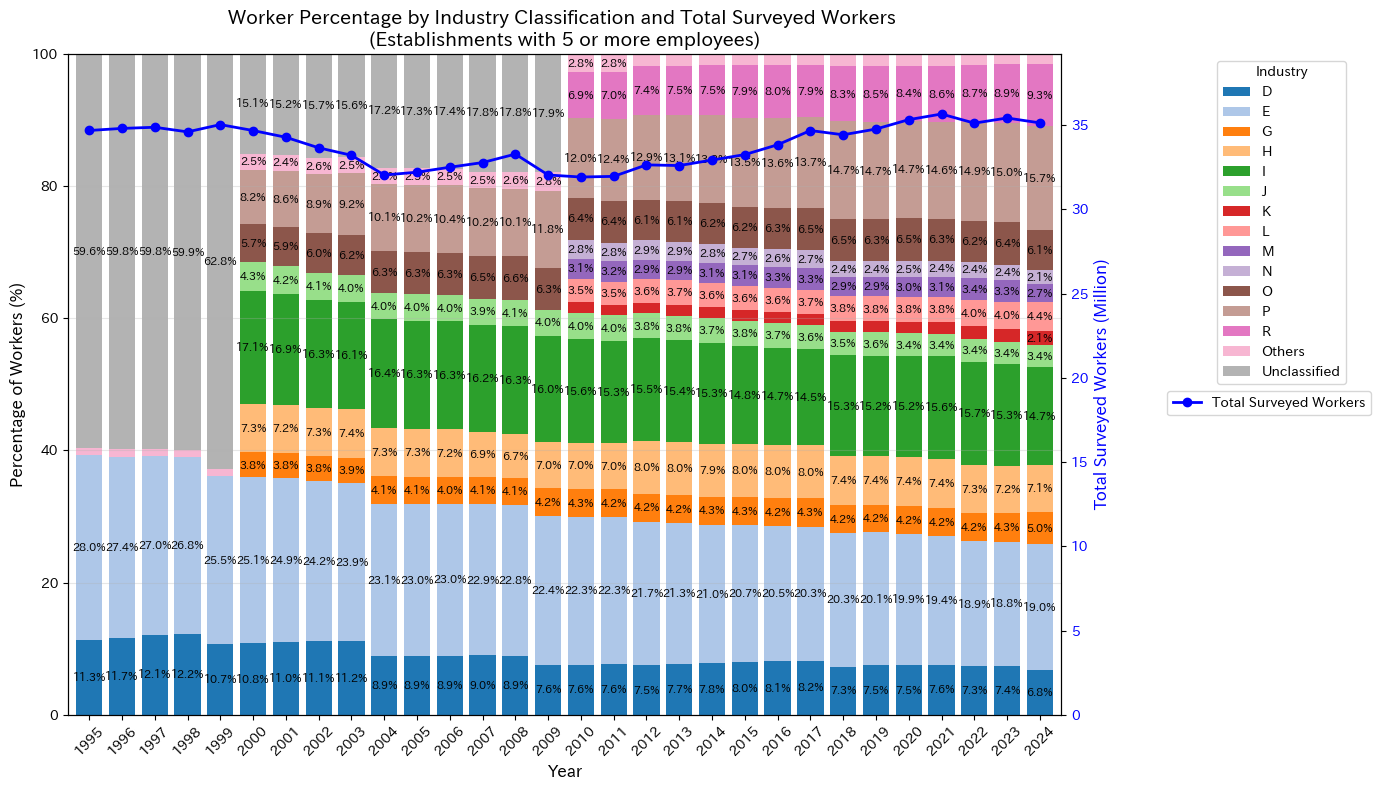

In [19]:
# ピボットテーブルを作成(年 × 産業分類_新)
pivot_data = employees_data_grouped.pivot(index="年", columns="産業分類_新", values="労働者数割合").fillna(0)

# 100%に満たない部分を「未分類」として追加
pivot_data["Unclassified"] = 100 - pivot_data.sum(axis=1)

# 列名を英語に変換
column_mapping = {
    "その他": "Others",
    "未分類": "Unclassified"
}
pivot_data = pivot_data.rename(columns=column_mapping)

# より多様な色を生成するため、複数のカラーマップを組み合わせる
n_colors = len(pivot_data.columns)

# 色のリストを作成（tab20、Set3、Pairedを組み合わせて多様性を確保）
colors = []
cmap1 = cm.get_cmap('tab20', 20)
cmap2 = cm.get_cmap('Set3', 12)
cmap3 = cm.get_cmap('Paired', 12)

for i in range(n_colors):
    if i < 20:
        colors.append(cmap1(i))
    elif i < 32:
        colors.append(cmap2(i - 20))
    else:
        colors.append(cmap3(i - 32))

# 未分類は灰色に設定
if "Unclassified" in pivot_data.columns:
    colors[-1] = (0.7, 0.7, 0.7, 1.0)  # グレー

# 2軸グラフを作成
fig, ax1 = plt.subplots(figsize=(14, 8))

# 帯グラフをプロット(棒グラフとして)
pivot_data.plot(kind='bar', stacked=True, ax=ax1, width=0.8, color=colors, legend=False)

# 各バーに労働者数割合の値を表示
for i, year in enumerate(pivot_data.index):
    y_offset = 0
    for col in pivot_data.columns:
        value = pivot_data.loc[year, col]
        if value > 2.0:  # type: ignore # 2%以上の場合のみ表示
            ax1.text(i, y_offset + value / 2, f'{value:.1f}%',  # type: ignore
                    ha='center', va='center', fontsize=8, color='black', fontweight='bold')
        y_offset += value # type: ignore

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Percentage of Workers (%)", fontsize=12)
ax1.set_ylim(0, 100)
ax1.tick_params(axis='y')
plt.xticks(rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 第2軸を作成(調査対象労働者数の折れ線グラフ用)
ax2 = ax1.twinx()

# t_employees_dataから調査対象労働者数を取得
t_employees_sorted = t_employees_data.sort_values("年")

# 折れ線グラフをプロット(x座標はバーの位置に合わせる)
x_positions = range(len(pivot_data.index))
ax2.plot(x_positions, t_employees_sorted["労働者数"].values / 1000000,  # type: ignore
        color='blue', marker='o', linewidth=2, markersize=6, label='Total Surveyed Workers')

ax2.set_ylabel("Total Surveyed Workers (Million)", fontsize=12, color='blue')
ax2.set_ylim(0, t_employees_sorted["労働者数"].max() / 1000000 * 1.1)
ax2.tick_params(axis='y', labelcolor='blue')

# タイトルと凡例
plt.title("Worker Percentage by Industry Classification and Total Surveyed Workers \n(Establishments with 5 or more employees)", fontsize=14)

# 凡例を作成(帯グラフ用と折れ線グラフ用を統合)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# 帯グラフの凡例を左側に配置
ax1.legend(handles1, labels1, title="Industry", bbox_to_anchor=(1.15, 1), loc='upper left')
# 折れ線グラフの凡例を右上に配置
ax2.legend(handles2, labels2, bbox_to_anchor=(1.1, 0.5) , loc='upper left')

plt.tight_layout()
plt.show()

C:\Users\chika\AppData\Local\Temp\ipykernel_19700\2562081215.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('tab20', 20)
C:\Users\chika\AppData\Local\Temp\ipykernel_19700\2562081215.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap('Set3', 12)
C:\Users\chika\AppData\Local\Temp\ipykernel_19700\2562081215.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap3 = cm.get_cmap('Paired', 12)


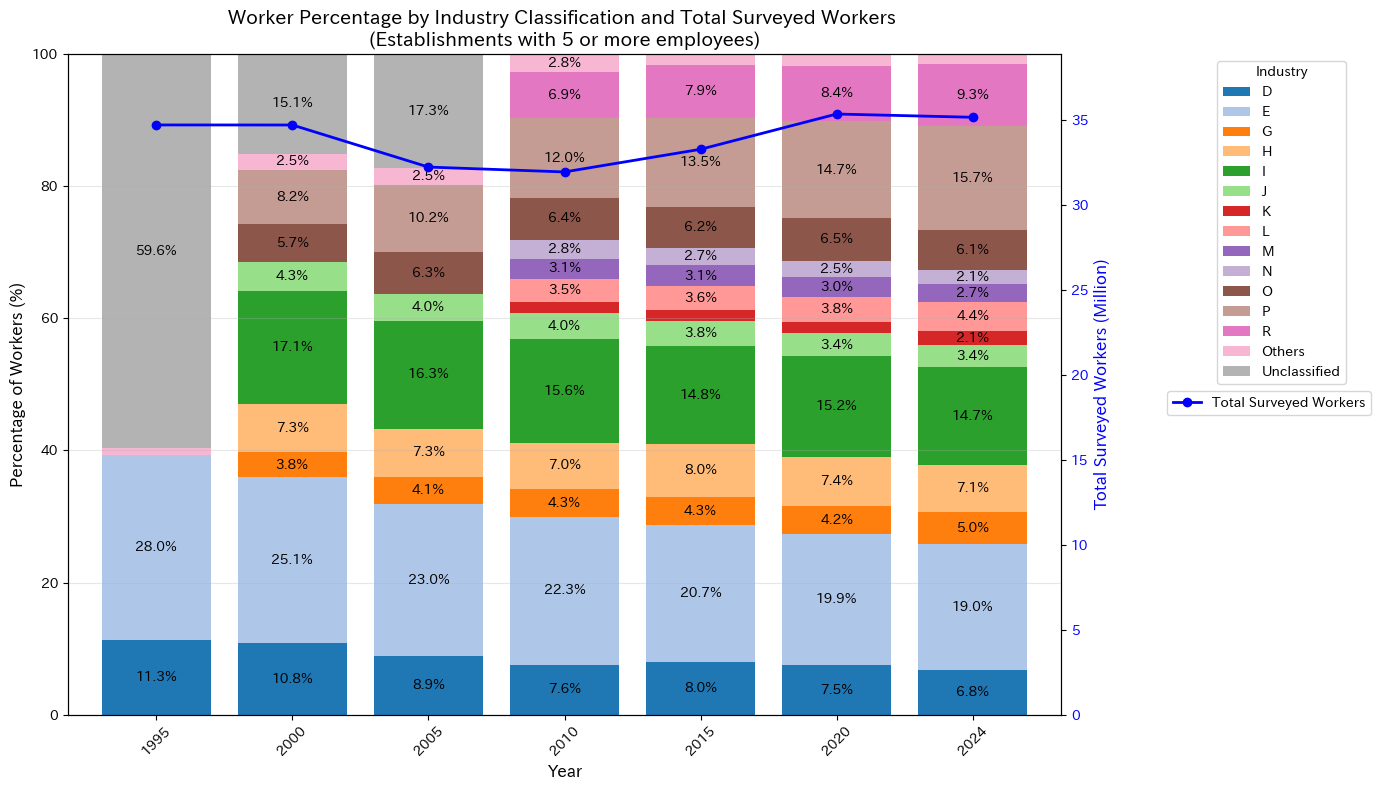

In [22]:
# ピボットテーブルを作成(年 × 産業分類_新)
pivot_data = employees_data_grouped.pivot(index="年", columns="産業分類_新", values="労働者数割合").fillna(0)

# 5年刻み（西暦が5で割り切れる年）と2024年のデータを抽出
target_years = sorted(list(set([y for y in pivot_data.index if y % 5 == 0] + [2024])))
# データに存在する年のみを対象にする
target_years = [y for y in target_years if y in pivot_data.index]
pivot_data = pivot_data.loc[target_years]

# 100%に満たない部分を「未分類」として追加
pivot_data["Unclassified"] = 100 - pivot_data.sum(axis=1)

# 列名を英語に変換
column_mapping = {
    "その他": "Others",
    "未分類": "Unclassified"
}
pivot_data = pivot_data.rename(columns=column_mapping)

# より多様な色を生成するため、複数のカラーマップを組み合わせる
n_colors = len(pivot_data.columns)

# 色のリストを作成（tab20、Set3、Pairedを組み合わせて多様性を確保）
colors = []
cmap1 = cm.get_cmap('tab20', 20)
cmap2 = cm.get_cmap('Set3', 12)
cmap3 = cm.get_cmap('Paired', 12)

for i in range(n_colors):
    if i < 20:
        colors.append(cmap1(i))
    elif i < 32:
        colors.append(cmap2(i - 20))
    else:
        colors.append(cmap3(i - 32))

# 未分類は灰色に設定
if "Unclassified" in pivot_data.columns:
    colors[-1] = (0.7, 0.7, 0.7, 1.0)  # グレー

# 2軸グラフを作成
fig, ax1 = plt.subplots(figsize=(14, 8))

# 帯グラフをプロット(棒グラフとして)
pivot_data.plot(kind='bar', stacked=True, ax=ax1, width=0.8, color=colors, legend=False)

# 各バーに労働者数割合の値を表示
for i, year in enumerate(pivot_data.index):
    y_offset = 0
    for col in pivot_data.columns:
        value = pivot_data.loc[year, col]
        if value > 2.0:  # type: ignore # 2%以上の場合のみ表示
            ax1.text(i, y_offset + value / 2, f'{value:.1f}%',  # type: ignore
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        y_offset += value # type: ignore

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Percentage of Workers (%)", fontsize=12)
ax1.set_ylim(0, 100)
ax1.tick_params(axis='y')
plt.xticks(rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 第2軸を作成(調査対象労働者数の折れ線グラフ用)
ax2 = ax1.twinx()

# t_employees_dataから調査対象労働者数を取得
t_employees_sorted = t_employees_data.sort_values("年")
# pivot_dataと同じ年にフィルタリング
t_employees_sorted = t_employees_sorted[t_employees_sorted["年"].isin(pivot_data.index)]

# 折れ線グラフをプロット(x座標はバーの位置に合わせる)
x_positions = range(len(pivot_data.index))
ax2.plot(x_positions, t_employees_sorted["労働者数"].values / 1000000,  # type: ignore
        color='blue', marker='o', linewidth=2, markersize=6, label='Total Surveyed Workers')

ax2.set_ylabel("Total Surveyed Workers (Million)", fontsize=12, color='blue')
ax2.set_ylim(0, t_employees_sorted["労働者数"].max() / 1000000 * 1.1)
ax2.tick_params(axis='y', labelcolor='blue')

# タイトルと凡例
plt.title("Worker Percentage by Industry Classification and Total Surveyed Workers \n(Establishments with 5 or more employees)", fontsize=14)

# 凡例を作成(帯グラフ用と折れ線グラフ用を統合)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# 帯グラフの凡例を左側に配置
ax1.legend(handles1, labels1, title="Industry", bbox_to_anchor=(1.15, 1), loc='upper left')
# 折れ線グラフの凡例を右上に配置
ax2.legend(handles2, labels2, bbox_to_anchor=(1.1, 0.5) , loc='upper left')

plt.tight_layout()
plt.show()

- なんかおかしい
    - 2000年を境に、
        - E（製造業）の割合が急に減る
        - D（建設業）の割合も急に減る
        - I（卸売業、小売業）の割合が急に増える
        - O（教育、学習支援業）、G（情報通信業）、K（不動産業、物品賃貸業）P（医療、福祉）が出現
        - R（サービス業）もなんかおかしい
    - 2010年から、
        - N（生活関連サービス業、娯楽業）が出現
    - 2000年と2010年で、各産業の割合が急に変化しているので、分類カテゴリが変更・追加されている可能性あり
        - 2010年はリーマンショックかも

- 改定されてる！
    - [改定状況](https://www.e-stat.go.jp/classifications/terms/revisions/10?op=&search_word=&search_method=keyword&info1SearchFlg=1&info2SearchFlg=1&komokuSearchFlg=1&base_code=T&revision=04&search_kind=10&form_id=main_form&page=&isf1=1&isf2=1&isf3=0&ksf=1&sk=10&sm=keyword&sw=&sbs1=1&sbs2=0&sbs3=0)


In [405]:
# 1995年時点の産業分類カテゴリを取得
employees_1995 = employees_data_grouped[employees_data_grouped["年"] == 1995][["産業分類_新", "労働者数", "労働者数割合"]]
employees_1995["産業分類_新"].unique()

array(['D', 'E', 'その他'], dtype=object)

In [406]:
# 調査産業計（TL）の労働者数と、その他全産業の労働者数が一致するか確認
t_1995 = t_employees_data[t_employees_data["年"] == 1995]["労働者数"].values[0]
others_1995 = employees_1995["労働者数"].sum()

print(f"1995年の調査産業計（TL）の労働者数: {t_1995}")
print(f"1995年のその他全産業の労働者数の合計: {others_1995}")
print(f"差異: {t_1995 - others_1995}")

1995年の調査産業計（TL）の労働者数: 34684417.0
1995年のその他全産業の労働者数の合計: 14002996.0
差異: 20681421.0


In [407]:
# 2024年の調査産業計（TL）の労働者数と、その他全産業の労働者数が一致するか確認
t_2024 = t_employees_data[t_employees_data["年"] == 2024]["労働者数"].values[0]
others_2024 = employees_data_grouped[employees_data_grouped["年"] == 2024]["労働者数"].sum()
print(f"\n2024年の調査産業計（TL）の労働者数: {t_2024}")
print(f"2024年のその他全産業の労働者数の合計: {others_2024}")
print(f"差異: {t_2024 - others_2024}")


2024年の調査産業計（TL）の労働者数: 35135425.0
2024年のその他全産業の労働者数の合計: 35135427.0
差異: -2.0


- もしかして、事業所規模は企業の回答に依存している？
- なんで差異があるのかわかんねぇ

- 2024年の差異は、ほぼ誤差
- したがって、差異は「調査したけど、当時分類がなかったカテゴリ」として扱うのが妥当と判断する。